# Classification

In this part of the project, we are given a database (already pre-processed) consisting of images of simple drawings, that is to say drawings of ants and grapes. We have a binary classification task and will implement different models to carry out this task. 

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report
from time import time
import warnings
import random
warnings.filterwarnings("ignore")

%matplotlib notebook



In [98]:
ant = np.load('G_20_ant.npy')
grapes = np.load('G_20_grapes.npy')
print(grapes.shape)
X = np.vstack((ant, grapes))
y = [0]*len(ant)+[1]*len(grapes)

(1000, 784)


One image is composed of 28 x 28 pixels and is converted in a list of 784 elements, and for each object, there are 1000 drawings. The ant drawings will be labeled as 0 and the grapes'one will be labeled as 1 (hence using a binary classification loss). 

## SVM

In this part, we propose to use SVM in order to determine a classifier between our 2 classes.

Firstly, we split our data into a training and testing set, keeping 25% of the data for the testing set.

In [469]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)

We will have to find the best choice for the kernel, as well as for the choices of hyperparameters.

# Choices of best parameters and kernel

In [470]:
parameters = {'C': [0.1, 1, 10, 100],   
              'gamma':['scale', 'auto'],
              'degree':[2,3,4],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       256
           1       0.87      0.91      0.89       244

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



In [471]:
print(clf.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [472]:
print("test score", clf.score(X_test, Y_test))

test score 0.89


<IPython.core.display.Javascript object>


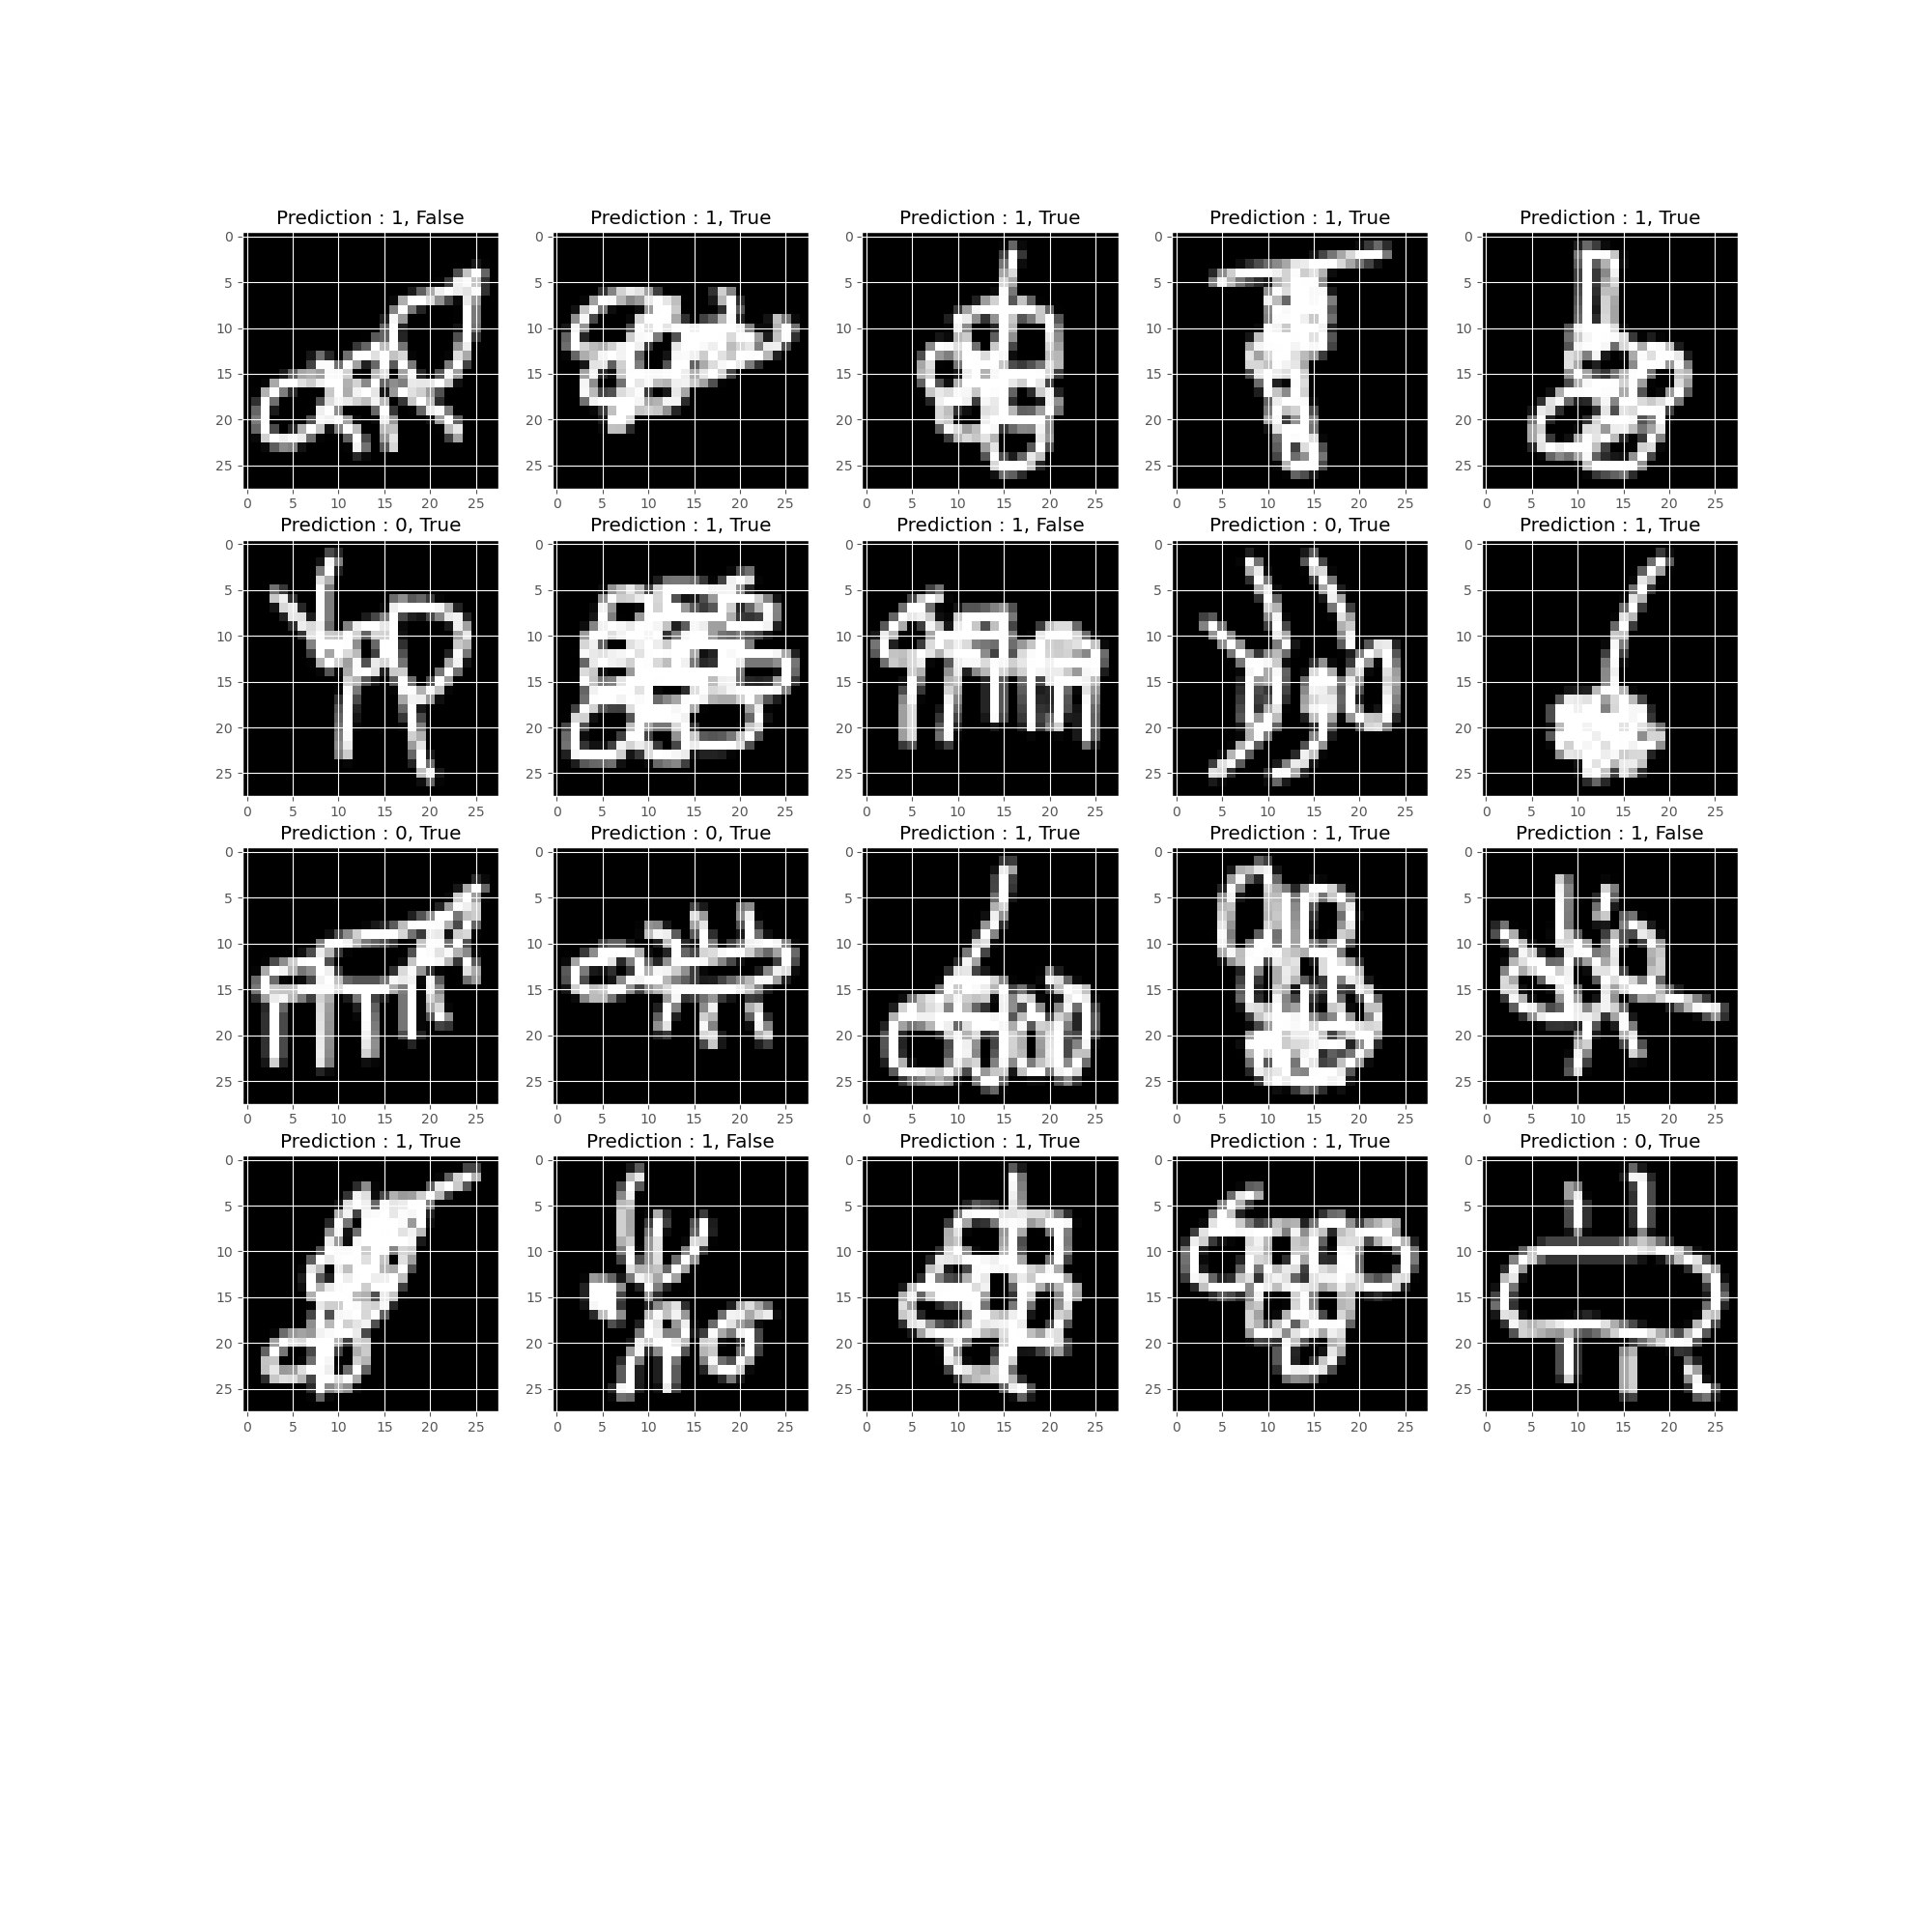

In [478]:
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if prediction[tpm] != Y_test[tpm]:
        correct = False
    if prediction[tpm]==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))

## Decision tree

Now we will build a binary decision tree. The challenge here is to find the best sepration/split so the impurity criterion and the stopping criterion (maximum depth or number of minimal number of data reached at a node, here we choose the stoping criterion to be a maximum depth reached).
For the impurity criterion, we will decide between GINI index and cross-entropy. Regarding the sopping criterion, we will use cross-validation.

In [576]:
from sklearn import tree
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [577]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)

### GINI index

First, let us see the tree for the GINI index and for the maximum depth that can be reached until all leaves are pure or until all leaves contain less than 2 samples :

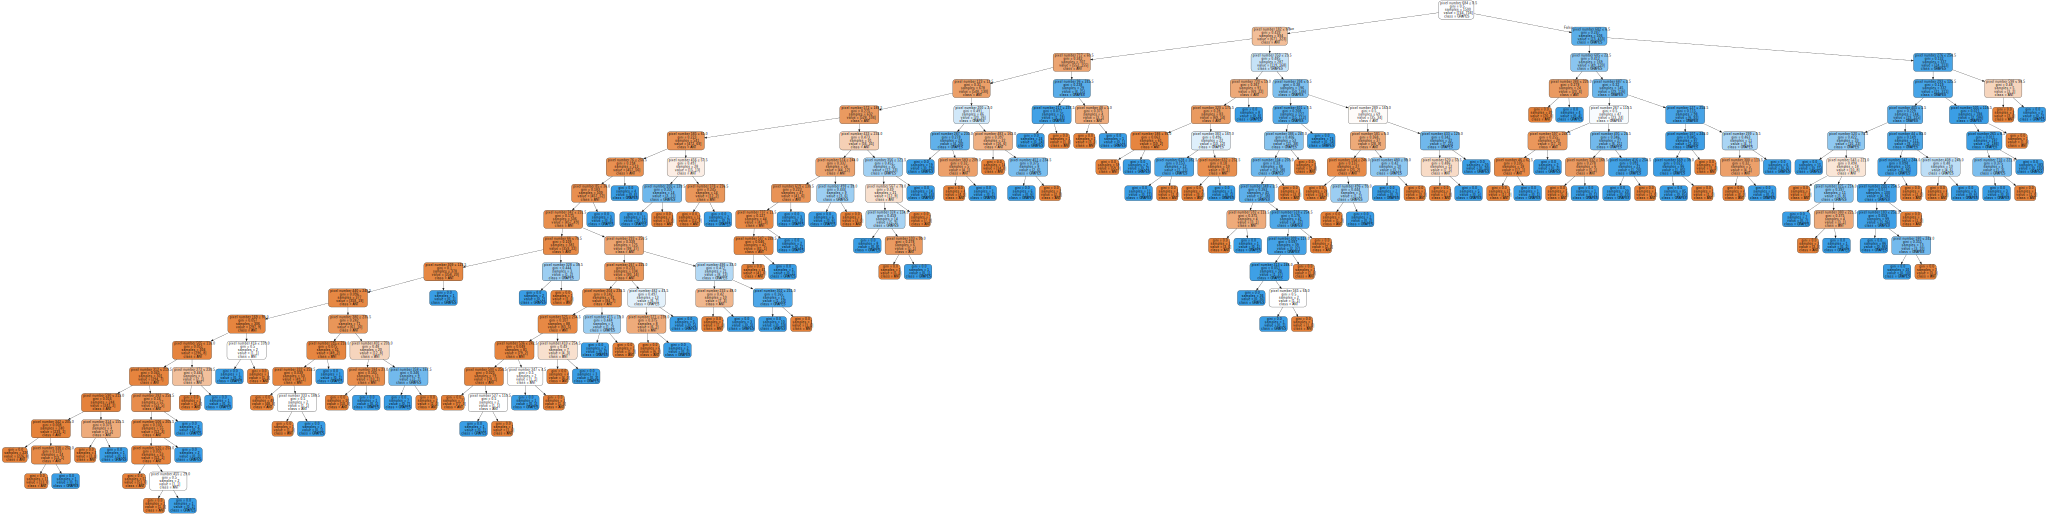

In [578]:
clf = tree.DecisionTreeClassifier(criterion = 'gini')
clf = clf.fit(X_train, Y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["pixel number "+str(k) for k in range(784)],  
                         class_names=["ANT", "GRAPES"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)
graphv


In [137]:
print(clf.tree_.max_depth)
print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

19
training score 1.0
test score 0.728


We can see that there is overfitting, so we will look for the best depth thanks to cross-validation :

<IPython.core.display.Javascript object>


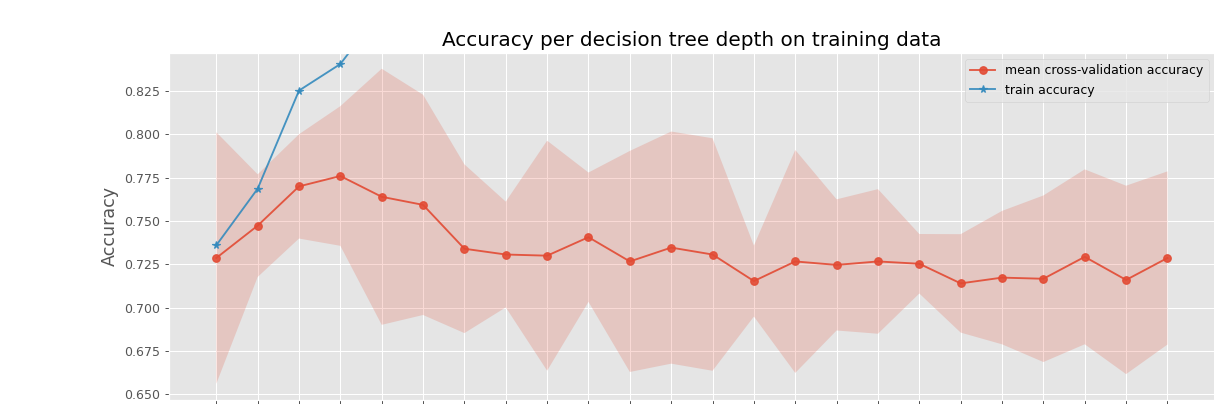

The depth-4 tree achieves the best mean cross-validation accuracy 77.6 +/- 2.0155% on training dataset


In [160]:
from sklearn.model_selection import cross_val_score


# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, Y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


Hence, the optimal depth is a depth of 4.

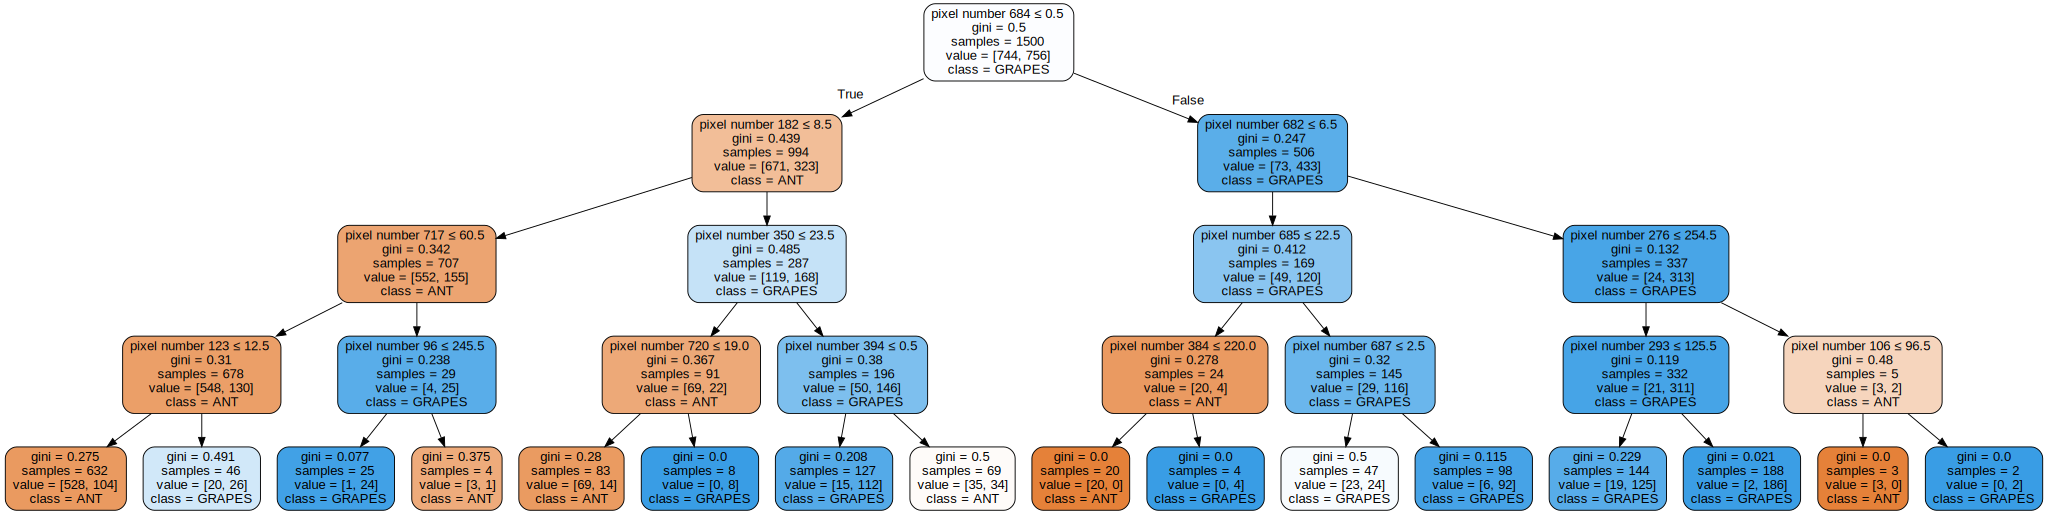

In [151]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 4)
clf = clf.fit(X_train, Y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=["pixel number "+str(k) for k in range(784)],  
                         class_names=["ANT", "GRAPES"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)
graphv


<IPython.core.display.Javascript object>


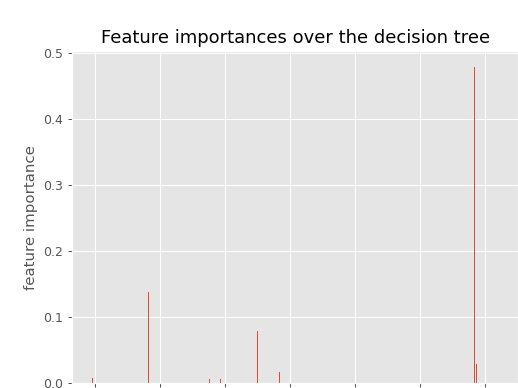

training score 0.8406666666666667
test score 0.802


In [159]:
features = []
index = []
for i,n in enumerate(clf.feature_importances_):
    if n!=0:
        features.append(n)
        index.append(i)
plt.close("all")
plt.bar(index, features)
plt.xlabel("feature (pixel number)")
plt.ylabel("feature importance")
plt.title("Feature importances over the decision tree")
plt.show()
print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

In [162]:
print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

training score 1.0
test score 0.78


# Choice of the best impurity criterion and stopping criterion

In [479]:
parameters = {'criterion':['gini', 'entropy'], 'max_depth':range(1,24)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters)
clf.fit(X_train, Y_train)
tree_model = clf.best_estimator_
print ("Mean cross-validated score of the best_estimator", clf.best_score_, "best parameters ", clf.best_params_) 

0.776 {'criterion': 'gini', 'max_depth': 4}


The best decision tree is given below :

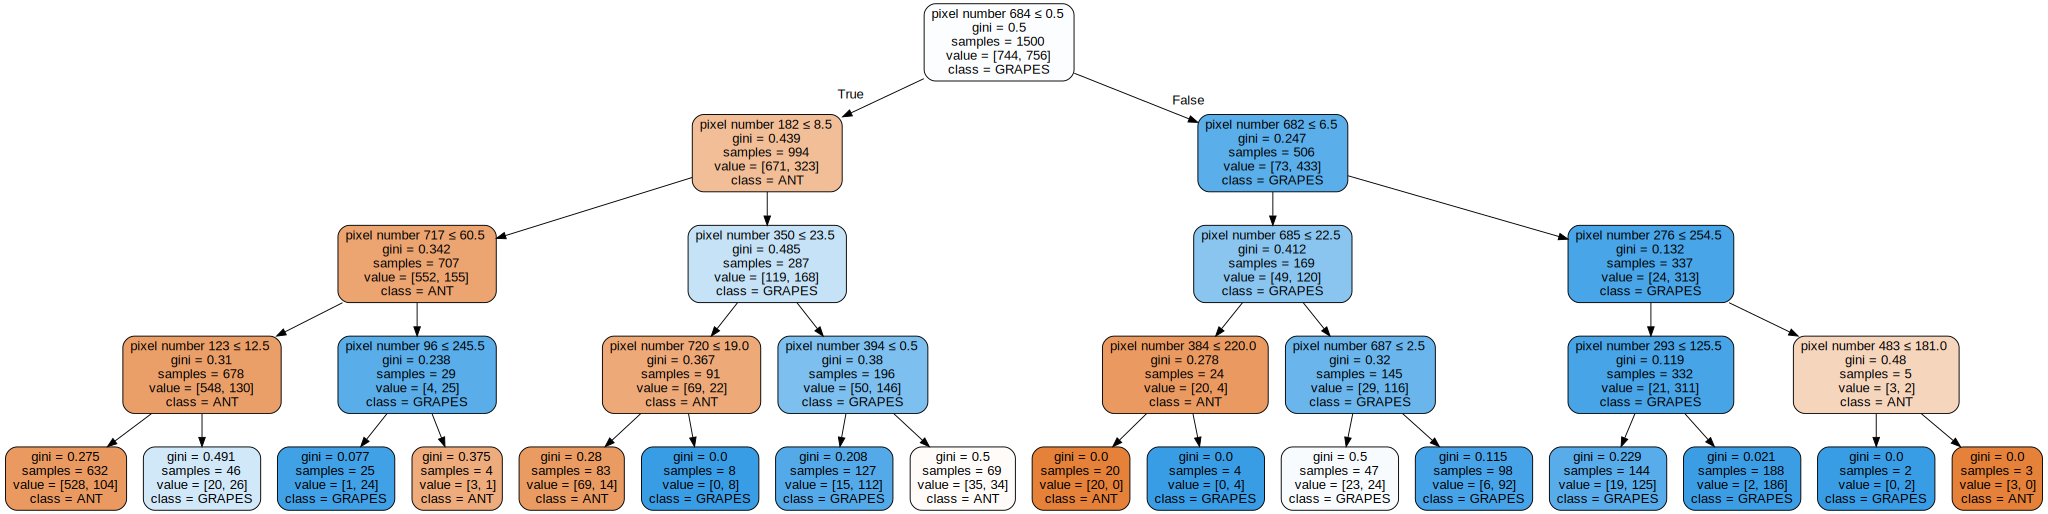

In [480]:
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=["pixel number "+str(k) for k in range(784)],  
                         class_names=["ANT", "GRAPES"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)
graphv

In [481]:
print("training score", tree_model.score(X_train, Y_train))
print("test score", tree_model.score(X_test, Y_test))

training score 0.8406666666666667
test score 0.804


<IPython.core.display.Javascript object>


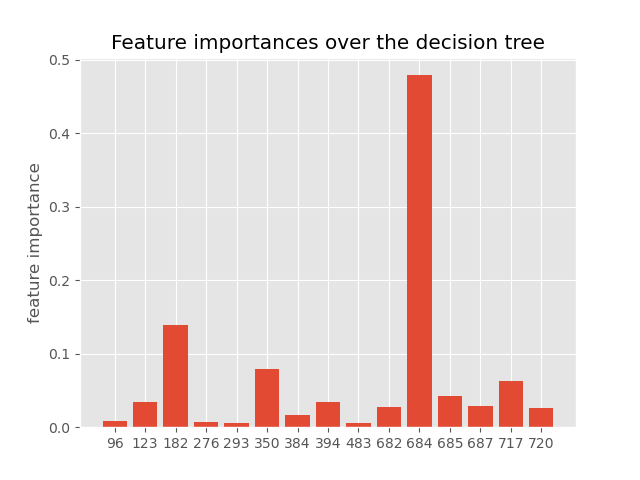

In [482]:
features = []
index = []
for i,n in enumerate(tree_model.feature_importances_):
    if n!=0:
        features.append(n)
        index.append(str(i))
plt.close("all")
plt.bar(index, features)
plt.xticks(range(len(index)), index)
plt.ylabel("feature importance")
plt.title("Feature importances over the decision tree")
plt.show()

<IPython.core.display.Javascript object>


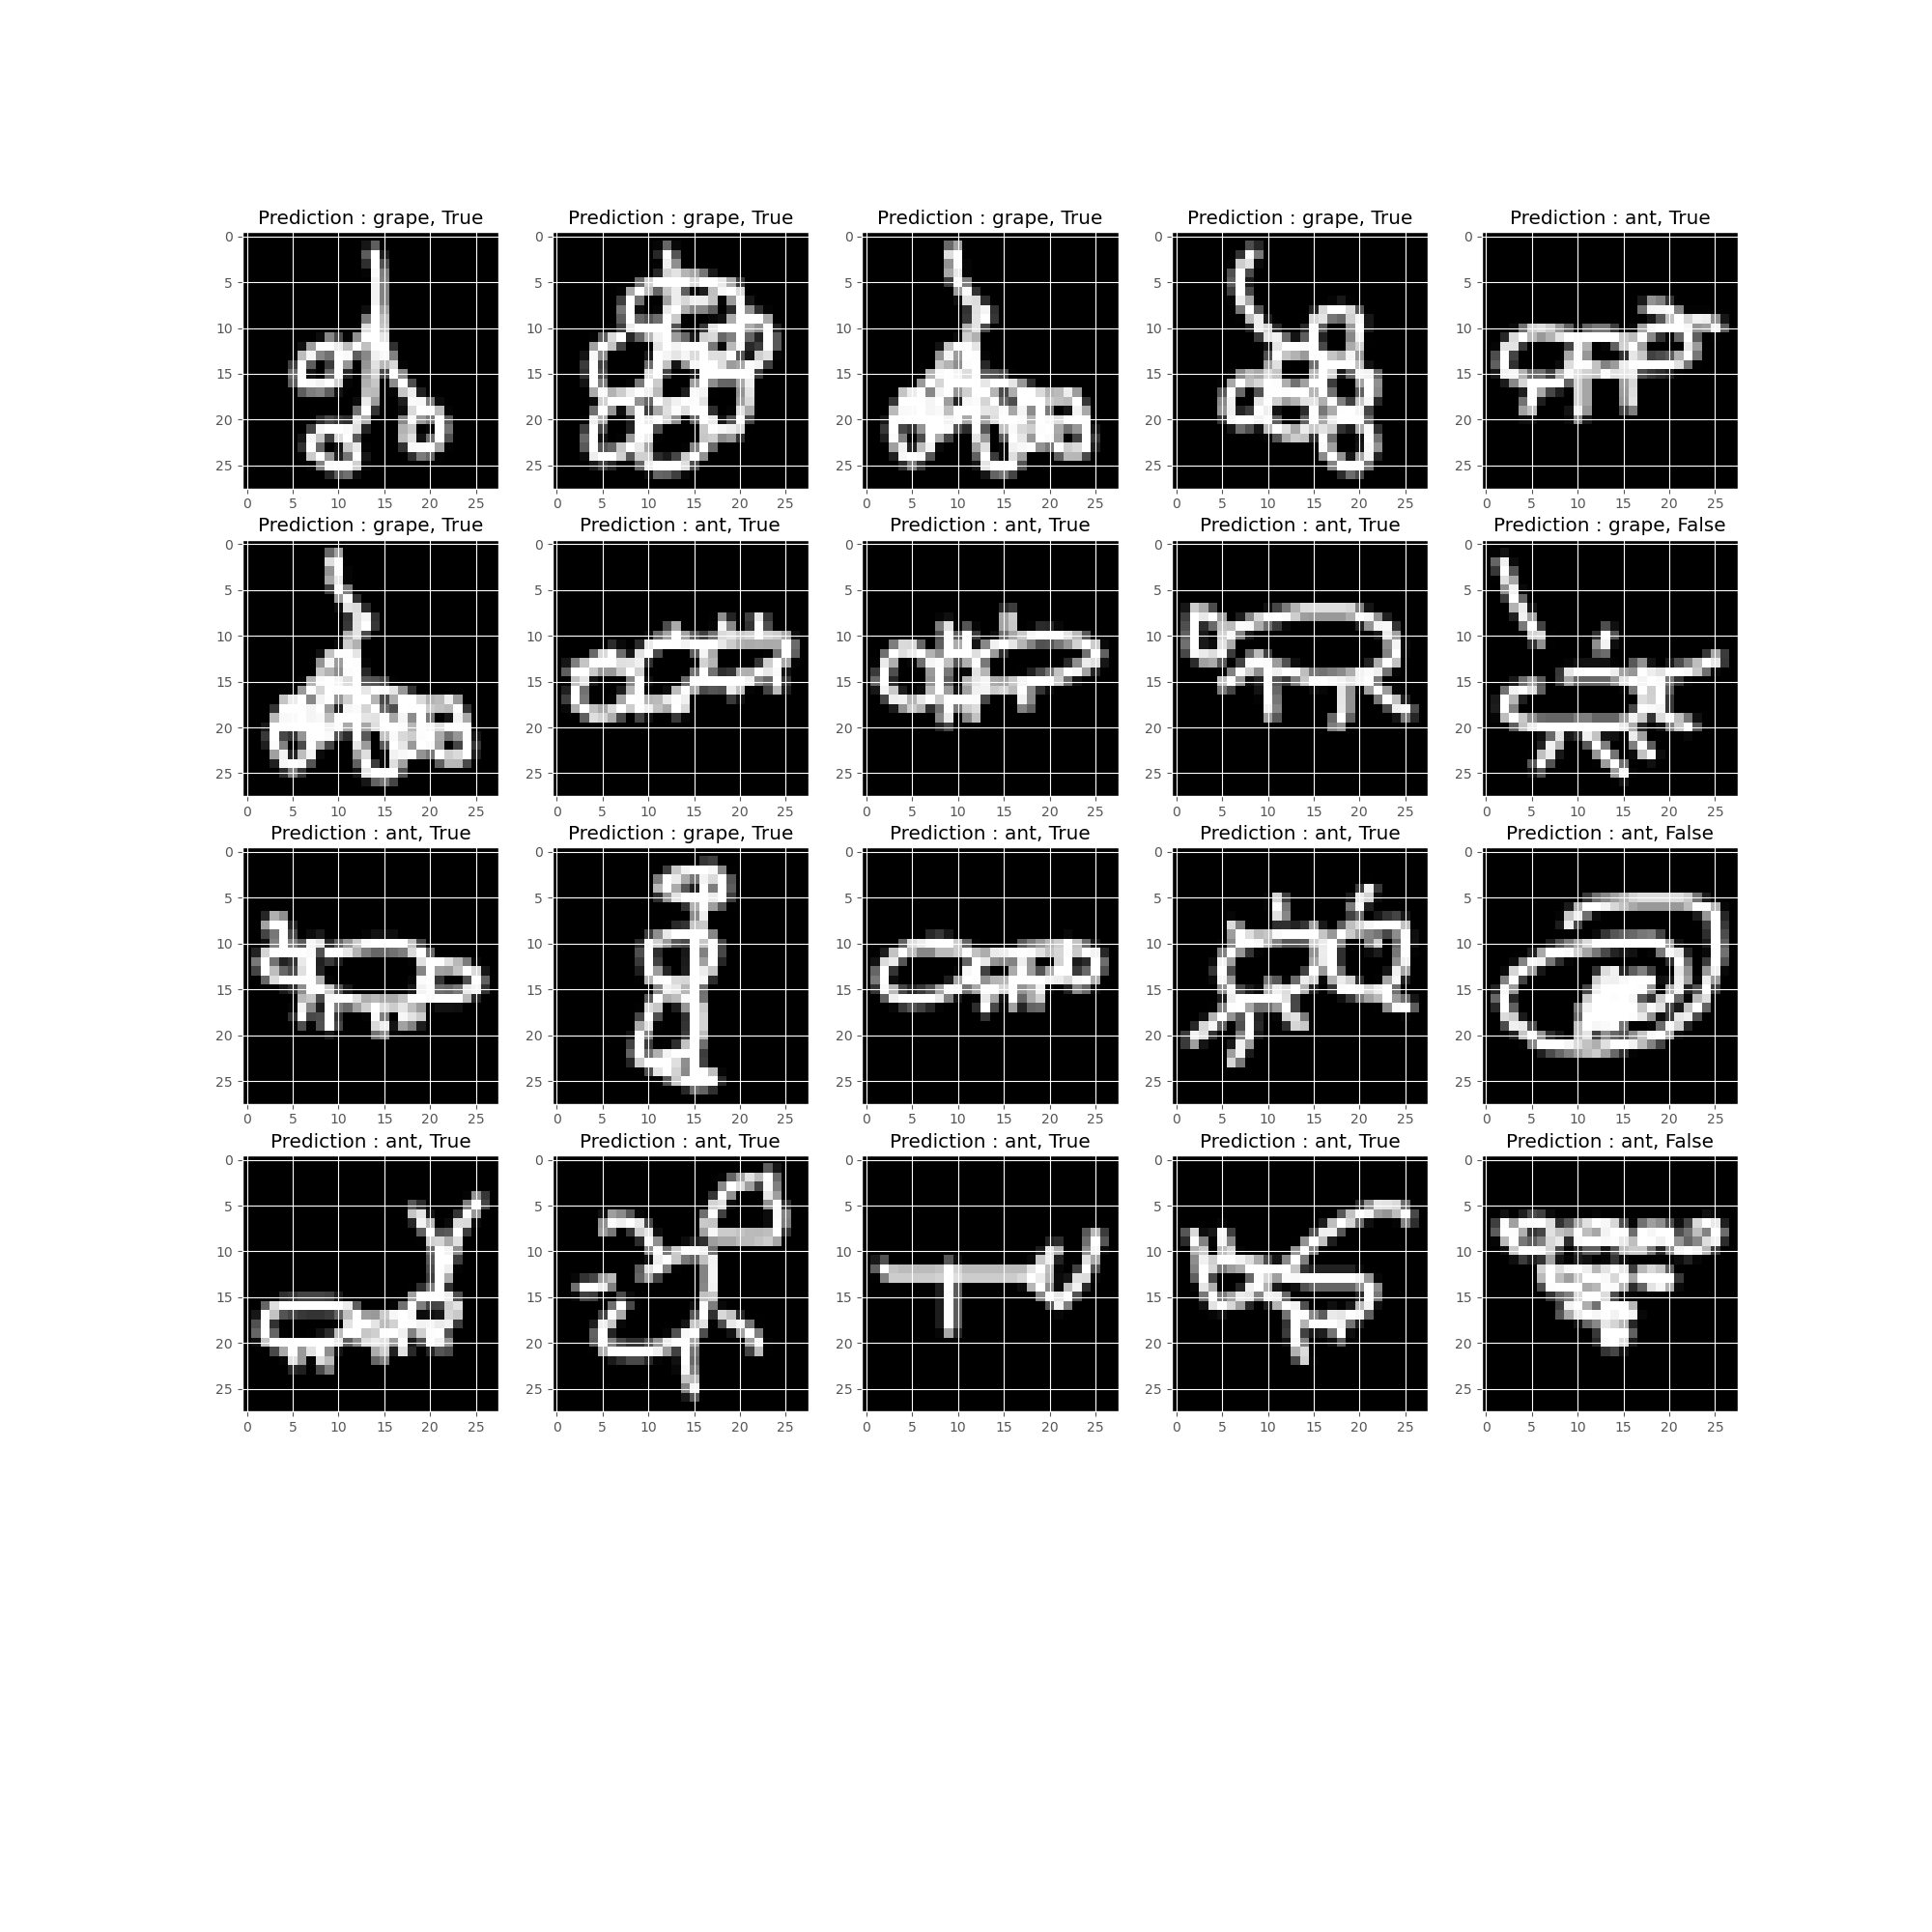

In [485]:
prediction = clf.predict(X_test)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if prediction[tpm] != Y_test[tpm]:
        correct = False
    if prediction[tpm]==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))

## Bagging for Decision tree

Let us see what bagging would result in

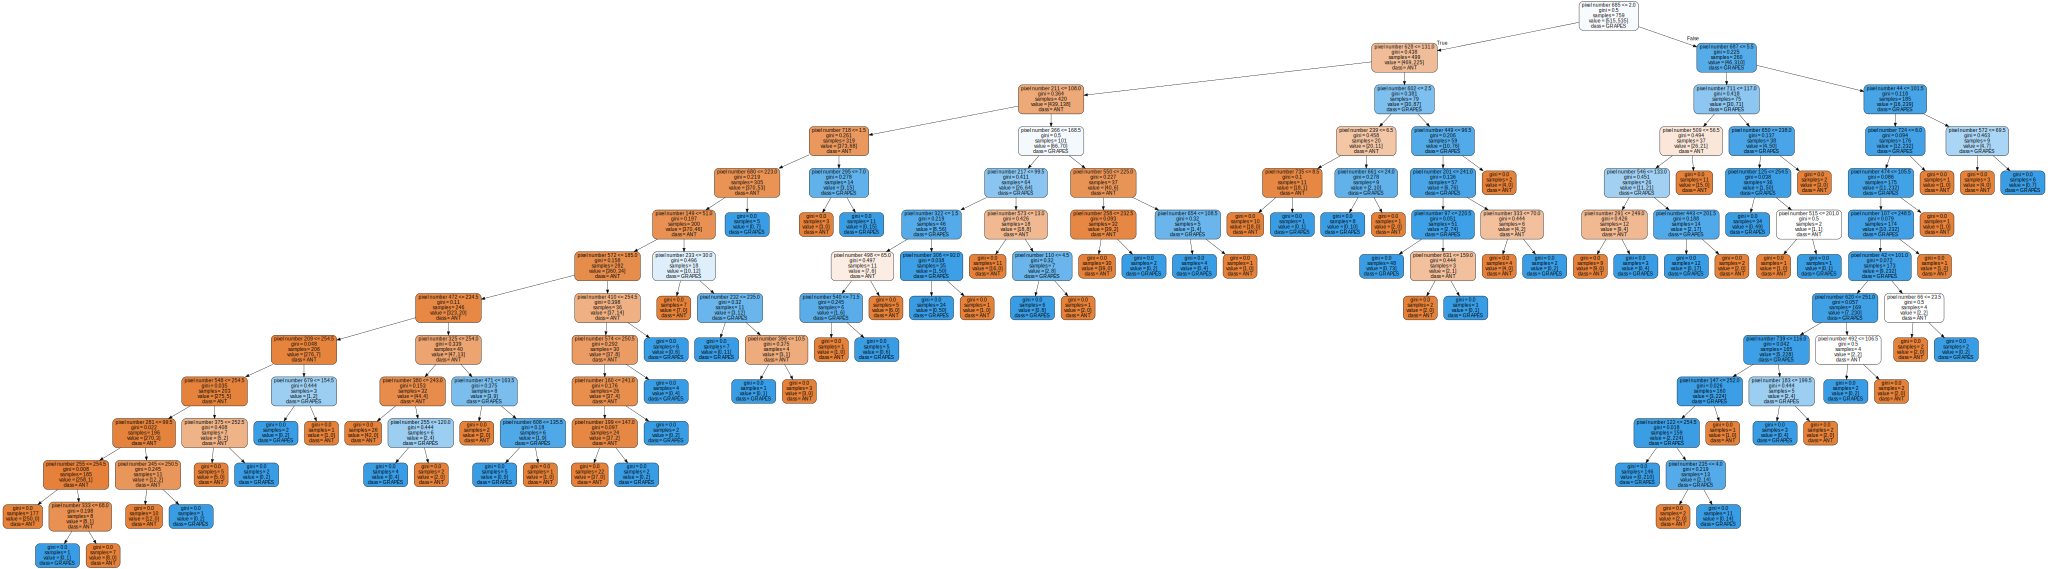

In [492]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(),
                       max_samples=0.7, random_state=0).fit(X_train, Y_train)
tree_model = clf.estimators_[0]
for estimator in clf.estimators_:
    if estimator.score(X_test, Y_test) > tree_model.score(X_test, Y_test):
        tree_model = estimator
# We plot the tree with the best testing score for illustration purpose
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=["pixel number "+str(k) for k in range(784)],  
                         class_names=["ANT", "GRAPES"],  
                         filled=True, rounded=True)  
graphv = graphviz.Source(dot_data)
graphv


In [496]:
print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

training score 0.97
test score 0.83


We can see that we slightly improved the performance of our classifier. However, if we impose the maximum depth found with the cross-validation previously, we obtain the following result, which is slightly better :

In [497]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=4),
                       max_samples=0.7, random_state=0).fit(X_train, Y_train)

print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

training score 0.862
test score 0.84


Hence we have slighlty improved the quality of our classifier using Bagging.

<IPython.core.display.Javascript object>


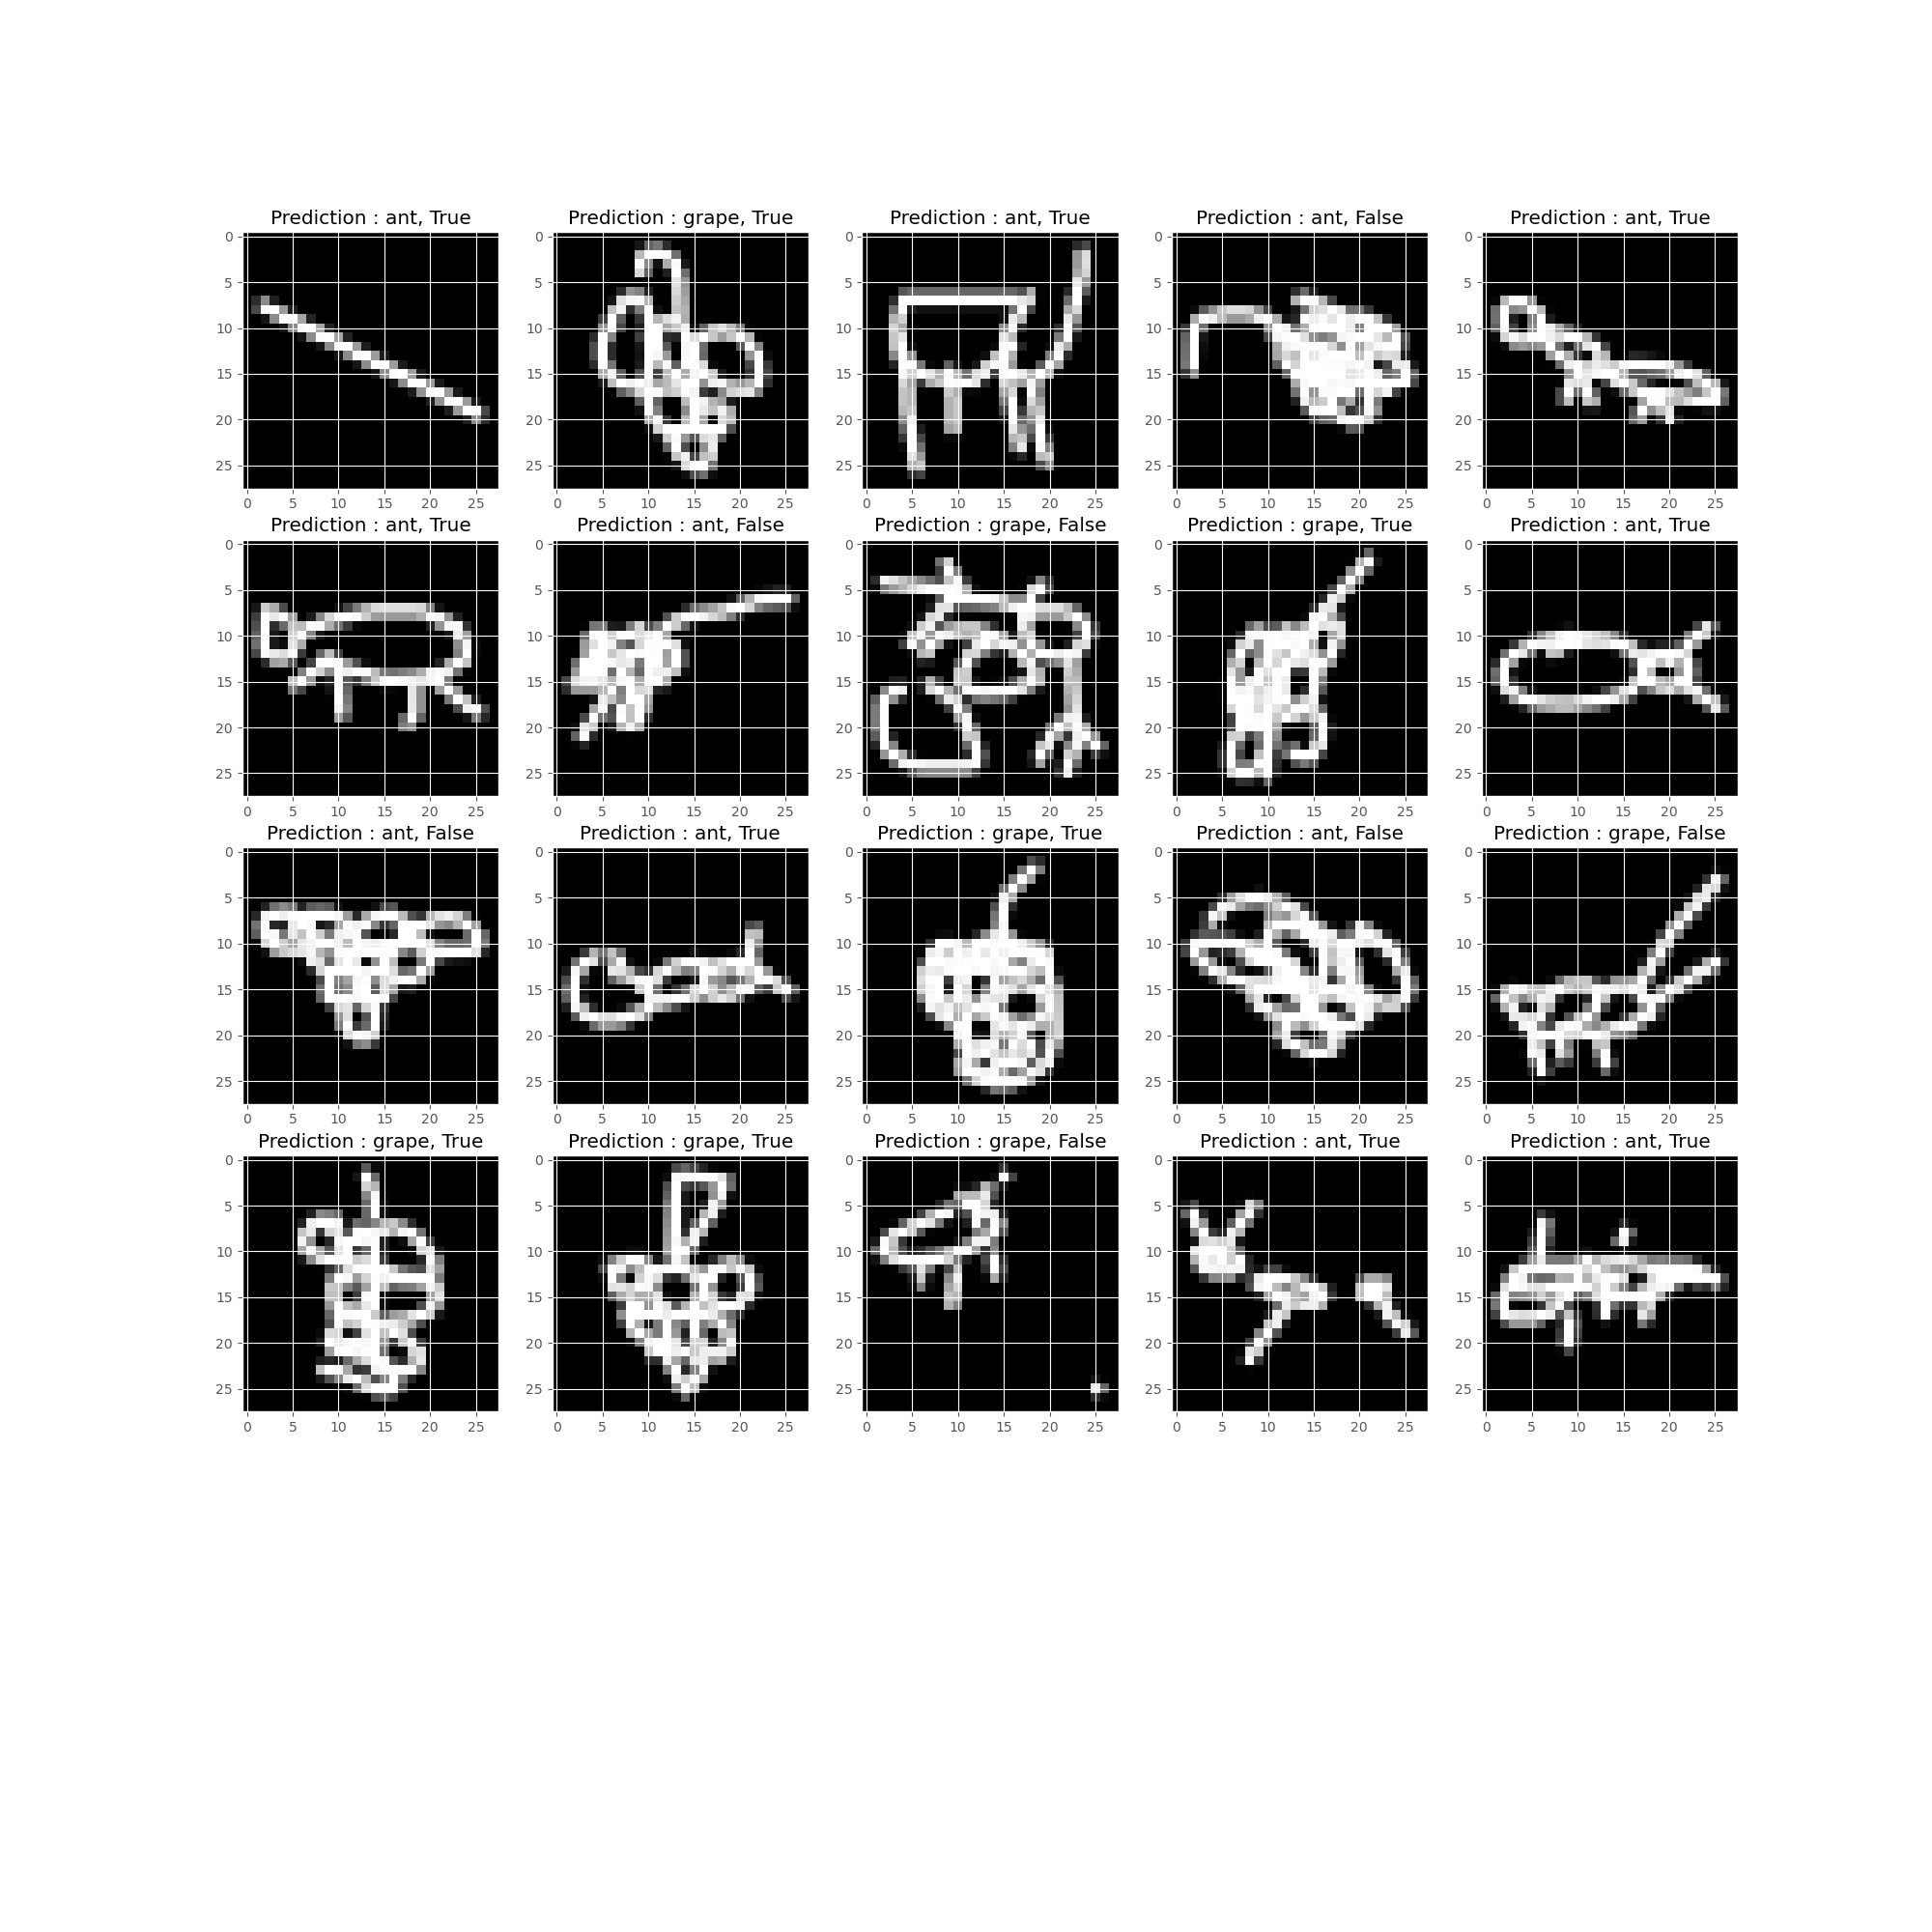

In [499]:
prediction = clf.predict(X_test)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if prediction[tpm] != Y_test[tpm]:
        correct = False
    if prediction[tpm]==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))

## Random Forest

Here, bootstrap samples are used when building trees as well.

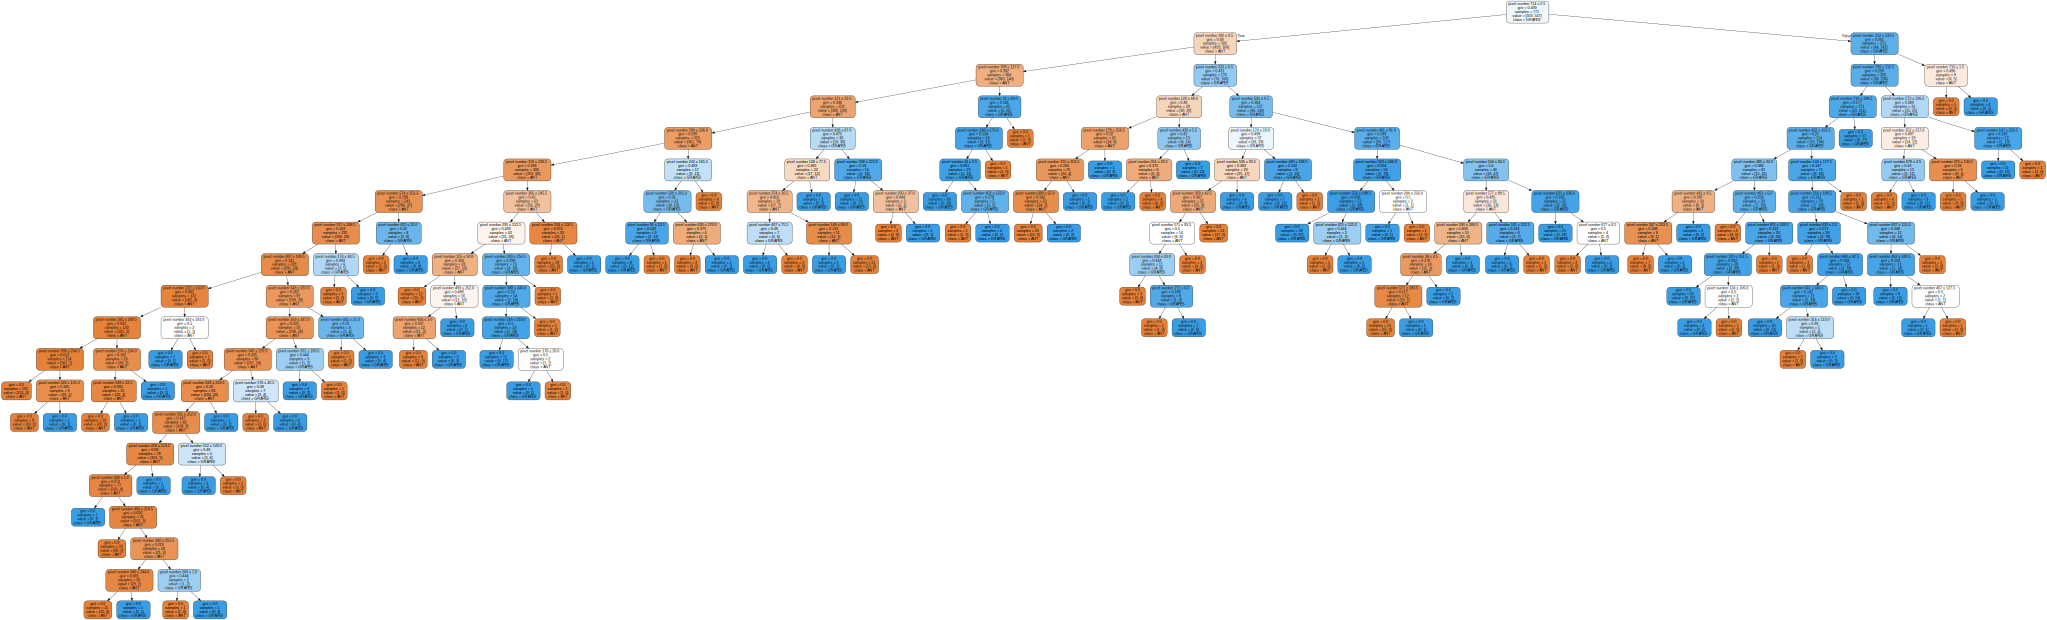

In [503]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2, max_samples=0.7).fit(X_train, Y_train)
tree_model = clf.estimators_[0]
for estimator in clf.estimators_:
    if estimator.score(X_test, Y_test) > tree_model.score(X_test, Y_test):
        tree_model = estimator
        
# We plot the tree with the best testing score for illustrating purpose
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=["pixel number "+str(k) for k in range(784)],  
                         class_names=["ANT", "GRAPES"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graphv = graphviz.Source(dot_data)
graphv

In [504]:
print("training score", clf.score(X_train, Y_train))
print("test score", clf.score(X_test, Y_test))

training score 0.998
test score 0.864


This classifier is a slightly better improvement than the previous decision tree classifiers, but slightly less good than the SVM.

<IPython.core.display.Javascript object>


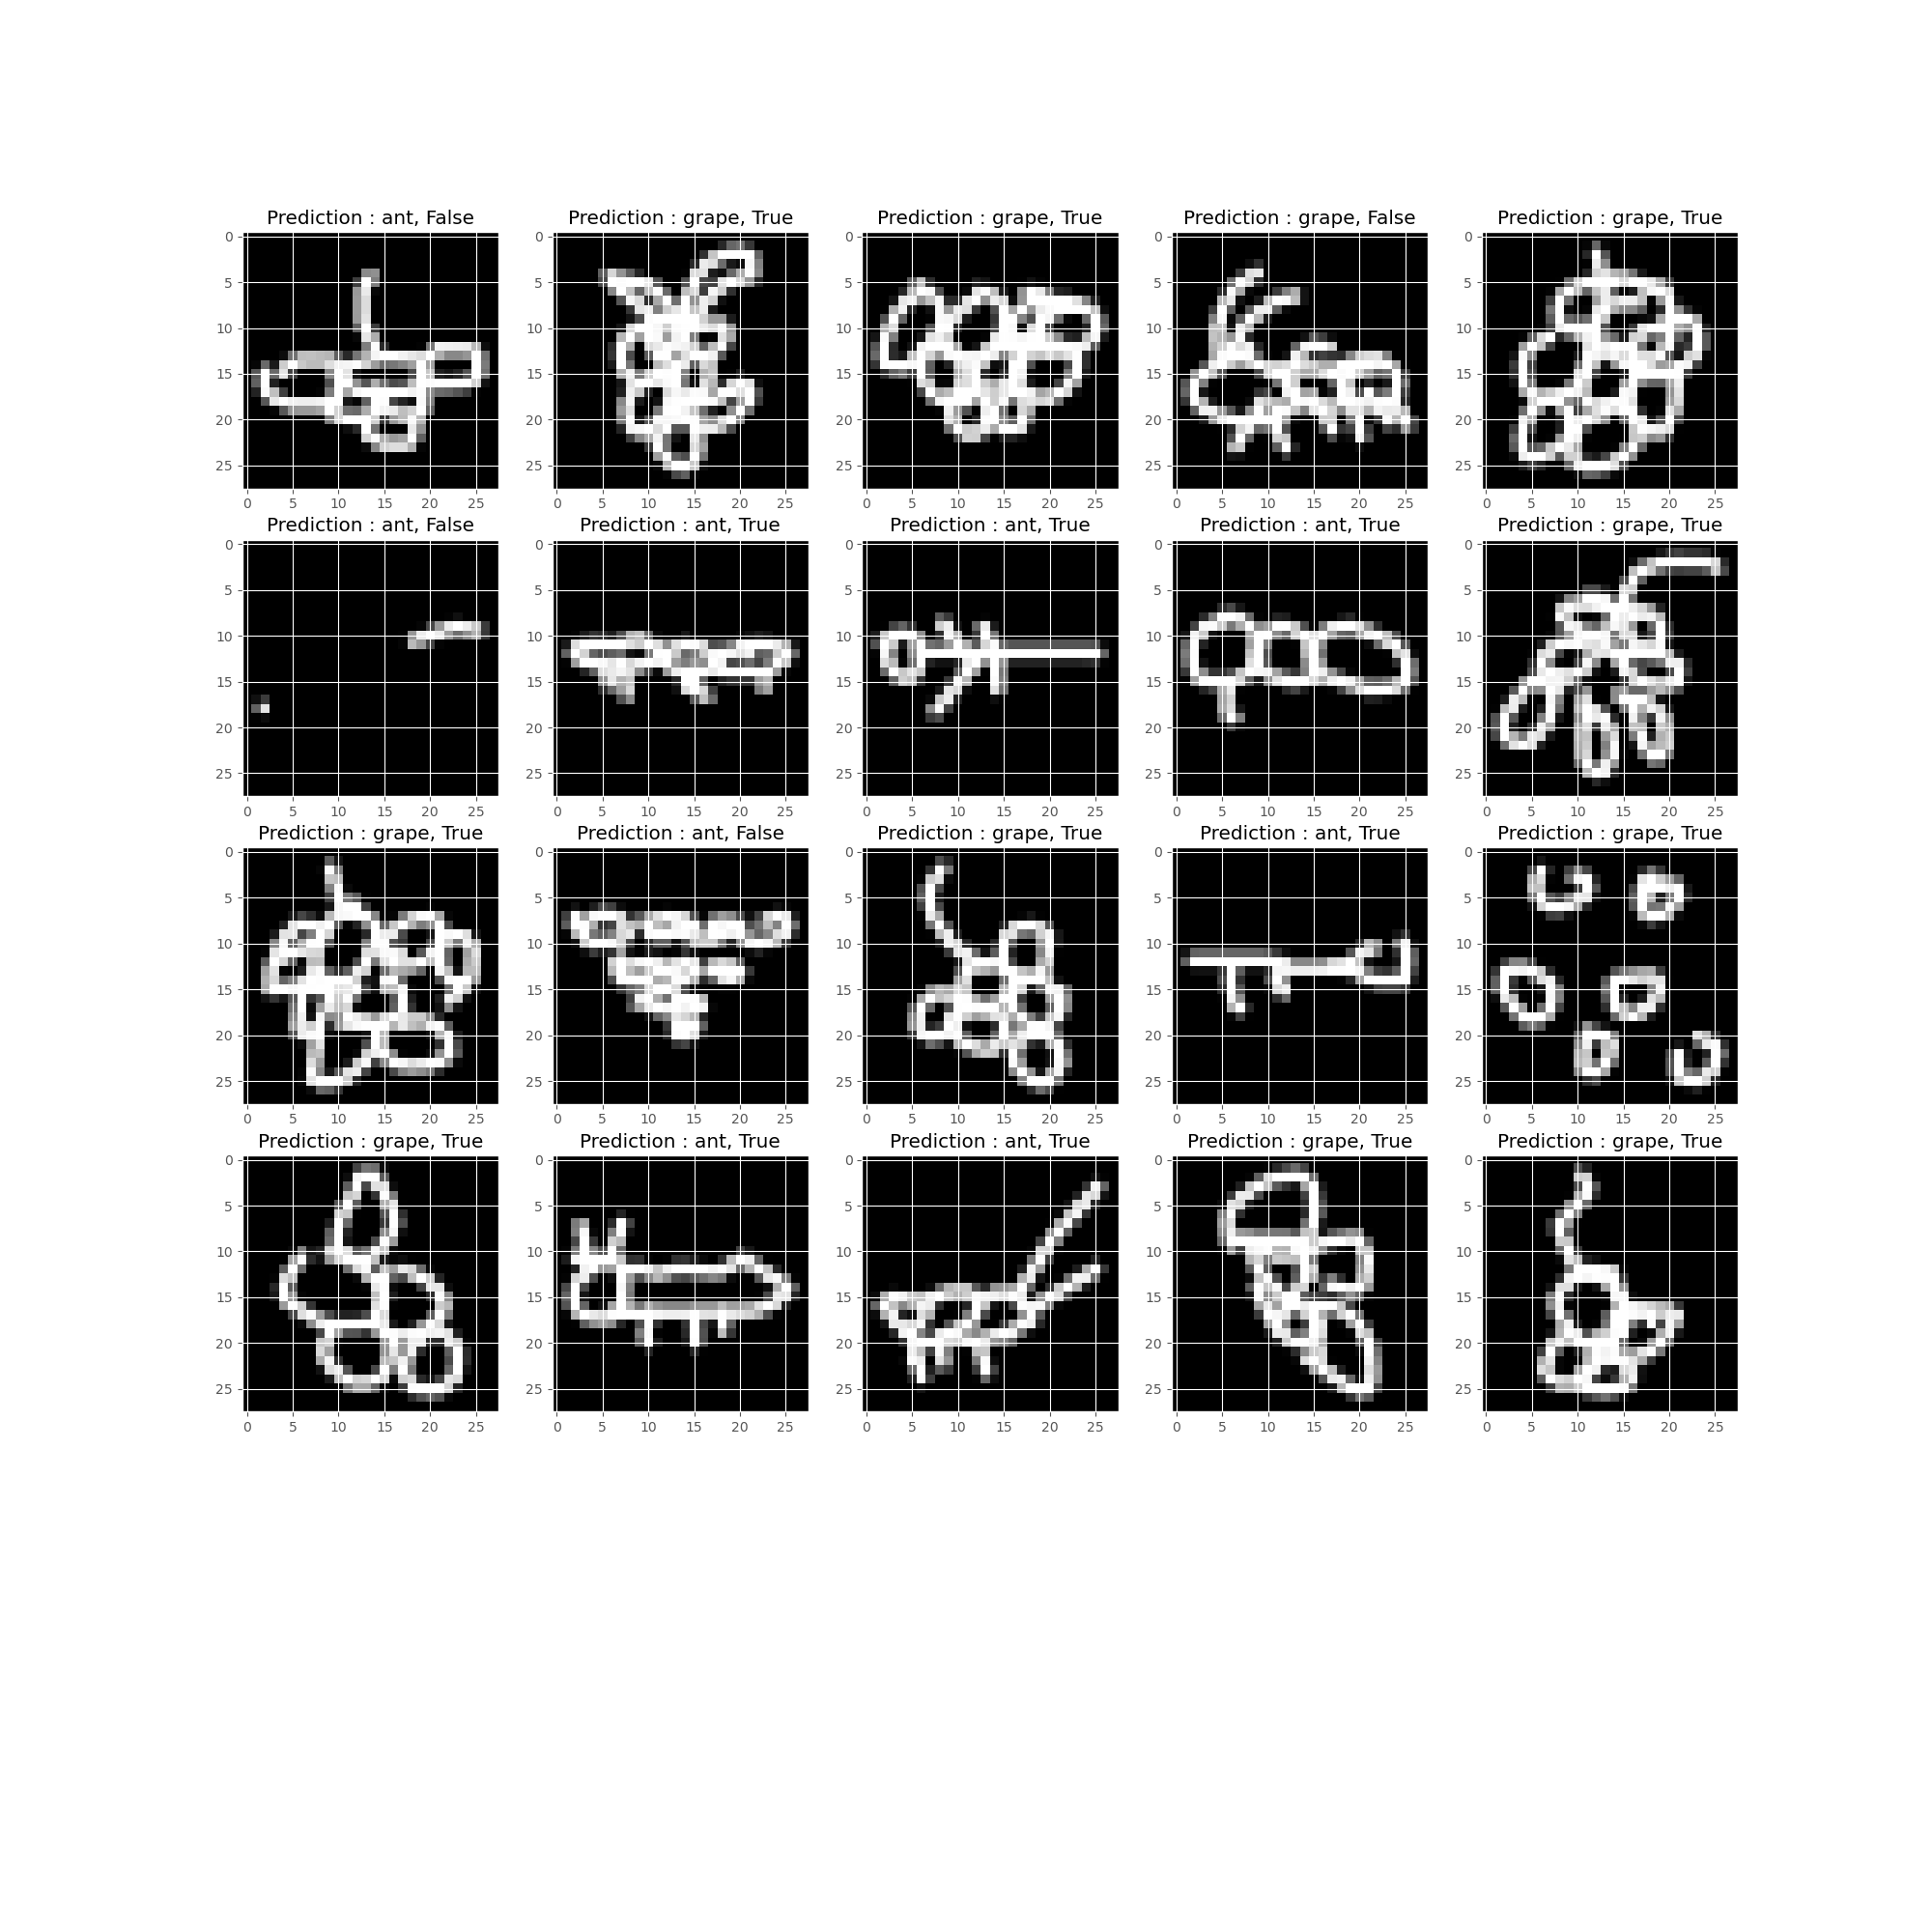

In [505]:
prediction = clf.predict(X_test)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if prediction[tpm] != Y_test[tpm]:
        correct = False
    if prediction[tpm]==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))

## AdaBoost 
Not necessary since we do not have a weak classifier

## Neuronal Network


In [557]:
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.3.0
Using keras version 2.4.3


We turn train and test labels to one-hot encoding using the following function:

In [518]:
from keras.utils.np_utils import to_categorical

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

We cast the pixels to floats, and normalize the images so that they have zero-mean and unitary deviation.

In [519]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

We will create a fully connected network.
For the fully connected layer, we are using this architecture: 
$$ (784) \rightarrow (300) \rightarrow (2) $$

In [531]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


input_shape = X_train.shape[1]
output_shape = 300
model = Sequential([
   Dense(output_shape, activation='sigmoid', input_shape=(input_shape,)),
    Flatten(),
   Dense(2, activation='softmax')])

Then we instantiate a SGD optimizer with a tentative learning rate of $\eta = 10^{-2}$ and compile the model using the ```'categorical_crossentropy'``` loss function

In [532]:
from keras import optimizers


model.compile(
   optimizer='sgd',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

# We can now have a look at the defined model topology
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 300)               235500    
_________________________________________________________________
flatten_64 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 2)                 602       
Total params: 236,102
Trainable params: 236,102
Non-trainable params: 0
_________________________________________________________________


### Training the network

First, in order to observe the behaviour, we train the model for 15 epochs using the ```.fit()``` method, validating the model at each epoch and keeping track of the training history for later plotting. We enable ```.fit()``` verbose mode in order to visualize the training.

In order to accelerate training, we use the ```batch_size``` option of ```.fit()```, which will process a batch of examples at the same time, and make one update for all of them, averaged over the gradients for each training example of the batch.

In [533]:
epochs = 15


history = model.fit(
   x=X_train,
   y=Y_train,
   epochs=epochs,
   batch_size=64,
    verbose = 1, 
   validation_data = (X_test, Y_test)
)

Epoch 1/15
24/24 [==============================] - 0s 9ms/step - loss: 0.6086 - accuracy: 0.7113 - val_loss: 0.5058 - val_accuracy: 0.8260
Epoch 2/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4934 - accuracy: 0.8200 - val_loss: 0.4353 - val_accuracy: 0.8480
Epoch 3/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4476 - accuracy: 0.8313 - val_loss: 0.4008 - val_accuracy: 0.8580
Epoch 4/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4238 - accuracy: 0.8380 - val_loss: 0.3810 - val_accuracy: 0.8680
Epoch 5/15
24/24 [==============================] - 0s 4ms/step - loss: 0.4081 - accuracy: 0.8473 - val_loss: 0.3668 - val_accuracy: 0.8700
Epoch 6/15
24/24 [==============================] - 0s 4ms/step - loss: 0.3971 - accuracy: 0.8513 - val_loss: 0.3581 - val_accuracy: 0.8700
Epoch 7/15
24/24 [==============================] - 0s 6ms/step - loss: 0.3882 - accuracy: 0.8540 - val_loss: 0.3528 - val_accuracy: 0.8720
Epoch 8/15
24/24 [==

### Visualizing the network performance

We visualize the training history using the ```pyplot``` package:
- In one graph, we plot the train and vaidation loss functions,
- In another graph, we plot the train and validation accuracy.

<IPython.core.display.Javascript object>


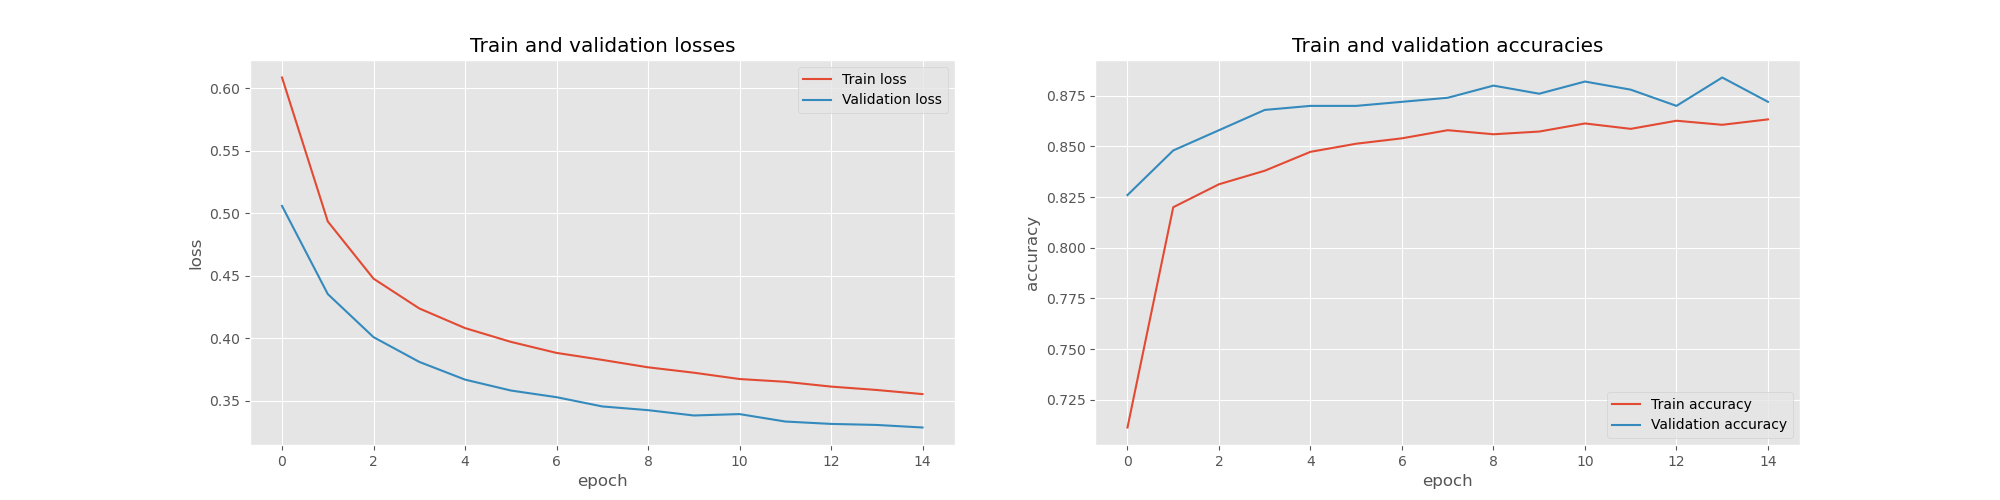

In [534]:
plt.close("all")
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Train and validation losses')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['Train loss', 'Validation loss'], loc='best')

# summarize history for accuracy
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Train and validation accuracies')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['Train accuracy', 'Validation accuracy'], loc='best')
plt.show()


In [536]:
model.evaluate(X_test, Y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.8720


[0.3285175561904907, 0.871999979019165]

In [437]:
accuracy = 0
epochs_optim = 2
batch_optim = 32
for epochs in range(2,21):
    for batch in [32*k for k in range(1,4)]:
        history = model.fit(
       x=X_train,
        y=Y_train,
       epochs=epochs,
       batch_size=batch,
        verbose = 0, 
       validation_data = (X_test, Y_test))
        if model.evaluate(X_test, Y_test, verbose=0)[1] > accuracy :
            accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
            epochs_optim = epochs
            batch_optim = batch
print(accuracy)
print(epochs_optim)
print(batch_optim)

16/16 [==============================] - 0s 1ms/step - loss: 0.5869 - accuracy: 0.8340
0.878000020980835
2
96


So it seems that 2 epochs and a batch_size of 96 are good hyperparameters

Epoch 1/2
16/16 [==============================] - 0s 6ms/step - loss: 0.3531 - accuracy: 0.8627 - val_loss: 0.3277 - val_accuracy: 0.8740
Epoch 2/2
16/16 [==============================] - 0s 5ms/step - loss: 0.3512 - accuracy: 0.8653 - val_loss: 0.3275 - val_accuracy: 0.8780


<IPython.core.display.Javascript object>


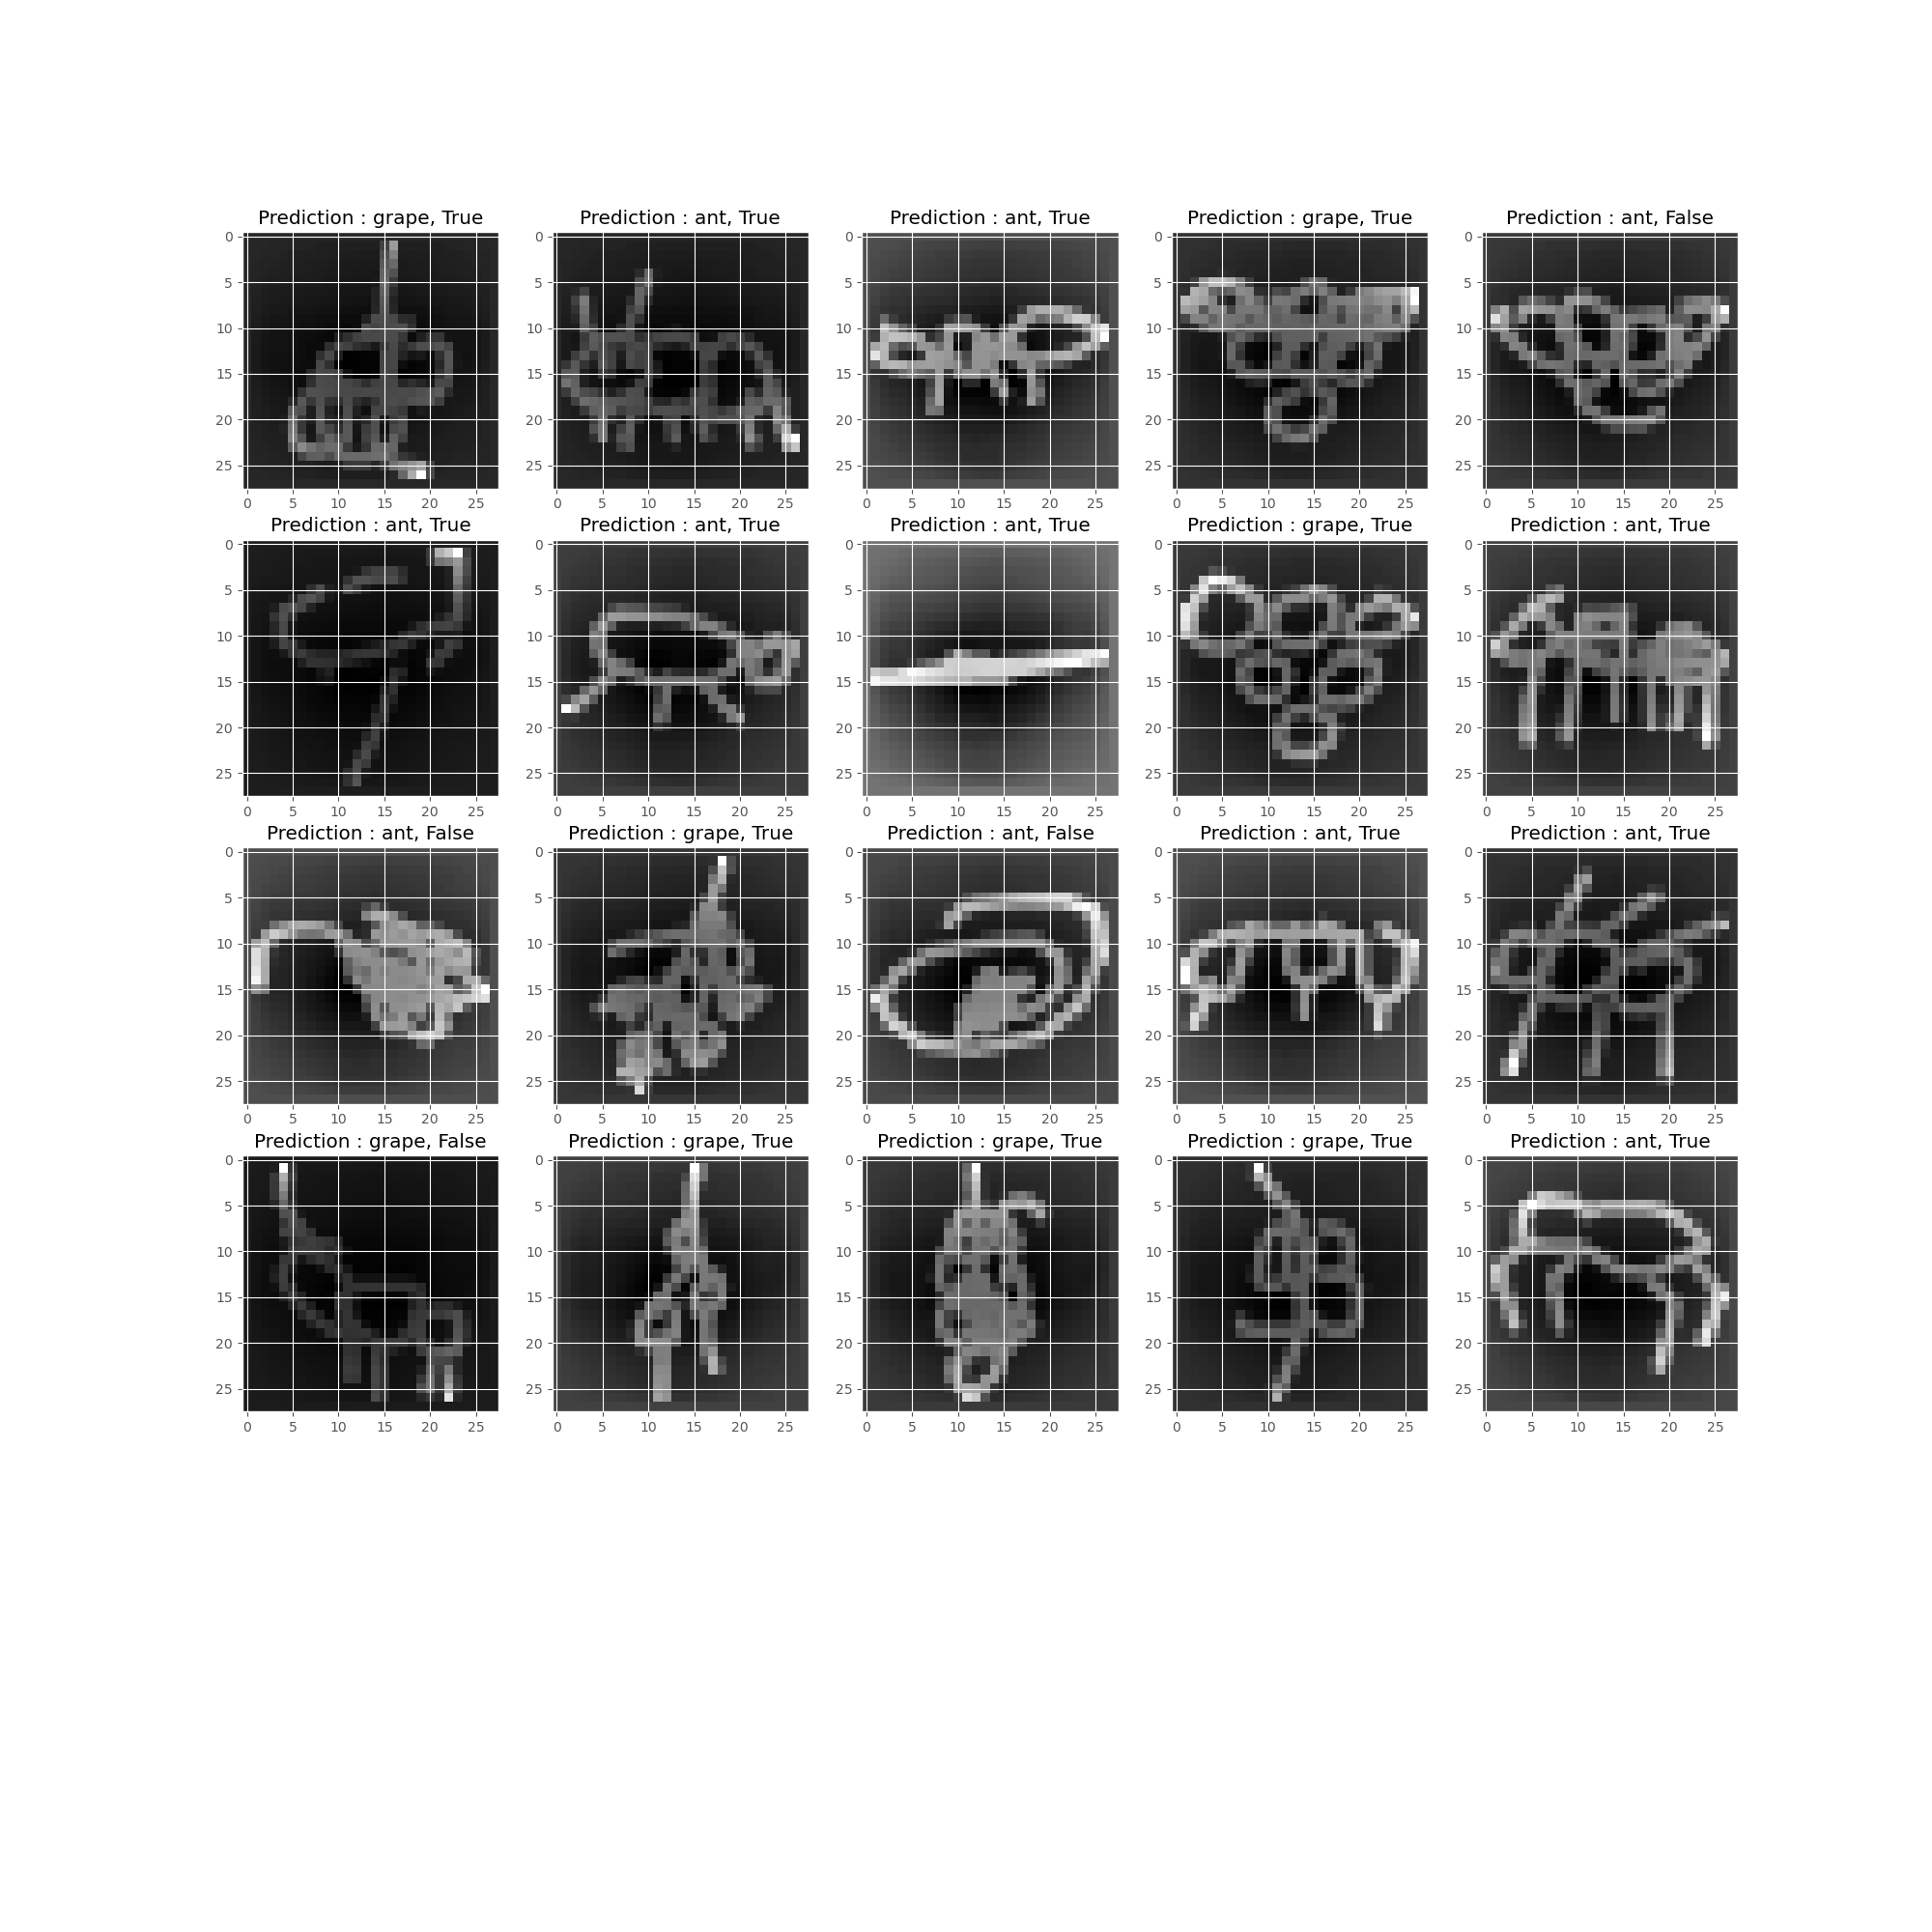

16/16 [==============================] - 0s 1ms/step - loss: 0.3275 - accuracy: 0.8780
[0.3274762034416199, 0.878000020980835]


In [537]:
model.fit(
   x=X_train,
   y=Y_train,
   epochs=2,
   batch_size=96,
    verbose = 1, 
   validation_data = (X_test, Y_test)
)
prediction = model.predict(
    x=X_test,
    batch_size=96,
    verbose=0
)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if np.argmax(prediction[tpm]) != np.argmax(Y_test[tpm]):
        correct = False
    if np.argmax(prediction[tpm])==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))
print(model.evaluate(X_test, Y_test))

With this classifier, we have an accuracy of roughly 0.878

### Replacing activation function by ReLu

In [538]:
epochs = 15
model = Sequential([
   Dense(output_shape, activation='relu', input_shape=(input_shape,)),
    Flatten(),
   Dense(2, activation='softmax')])
model.compile(
   optimizer='sgd',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)
history = model.fit(
   x=X_train,
   y=Y_train,
   epochs=epochs,
   batch_size=64,
    verbose = 0, 
   validation_data = (X_test, Y_test)
)

<IPython.core.display.Javascript object>


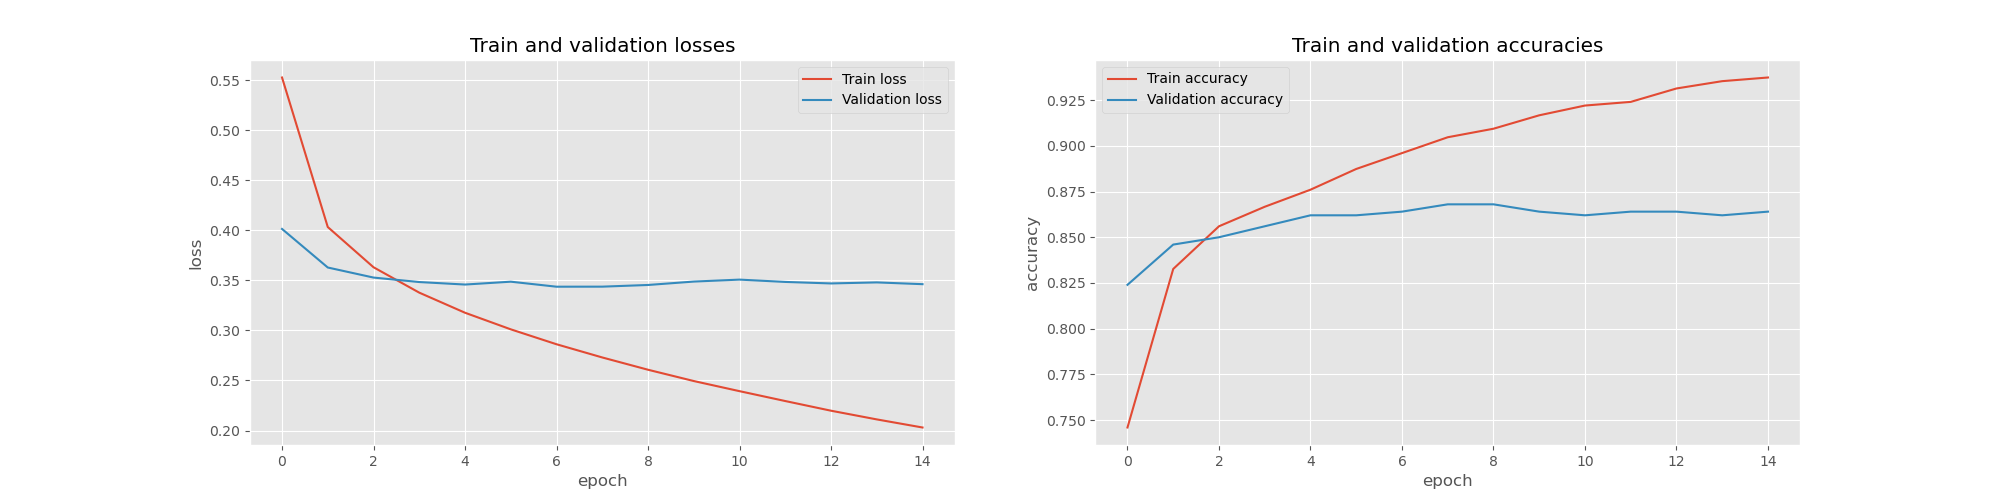

In [539]:
plt.close("all")
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Train and validation losses')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['Train loss', 'Validation loss'], loc='best')

# summarize history for accuracy
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Train and validation accuracies')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['Train accuracy', 'Validation accuracy'], loc='best')
plt.show()


In [540]:
model.evaluate(X_test, Y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.3462 - accuracy: 0.8640


[0.3462185859680176, 0.8640000224113464]

In [542]:
accuracy = 0
epochs_optim = 2
batch_optim = 32
for epochs in range(2,21):
    for batch in [32*k for k in range(1,4)]:
        history = model.fit(
       x=X_train,
        y=Y_train,
       epochs=epochs,
       batch_size=batch,
        verbose = 0, 
       validation_data = (X_test, Y_test))
        if model.evaluate(X_test, Y_test, verbose=0)[1] > accuracy :
            accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
            epochs_optim = epochs
            batch_optim = batch
print(accuracy)
print(epochs_optim)
print(batch_optim)

0.8640000224113464
2
32


<IPython.core.display.Javascript object>


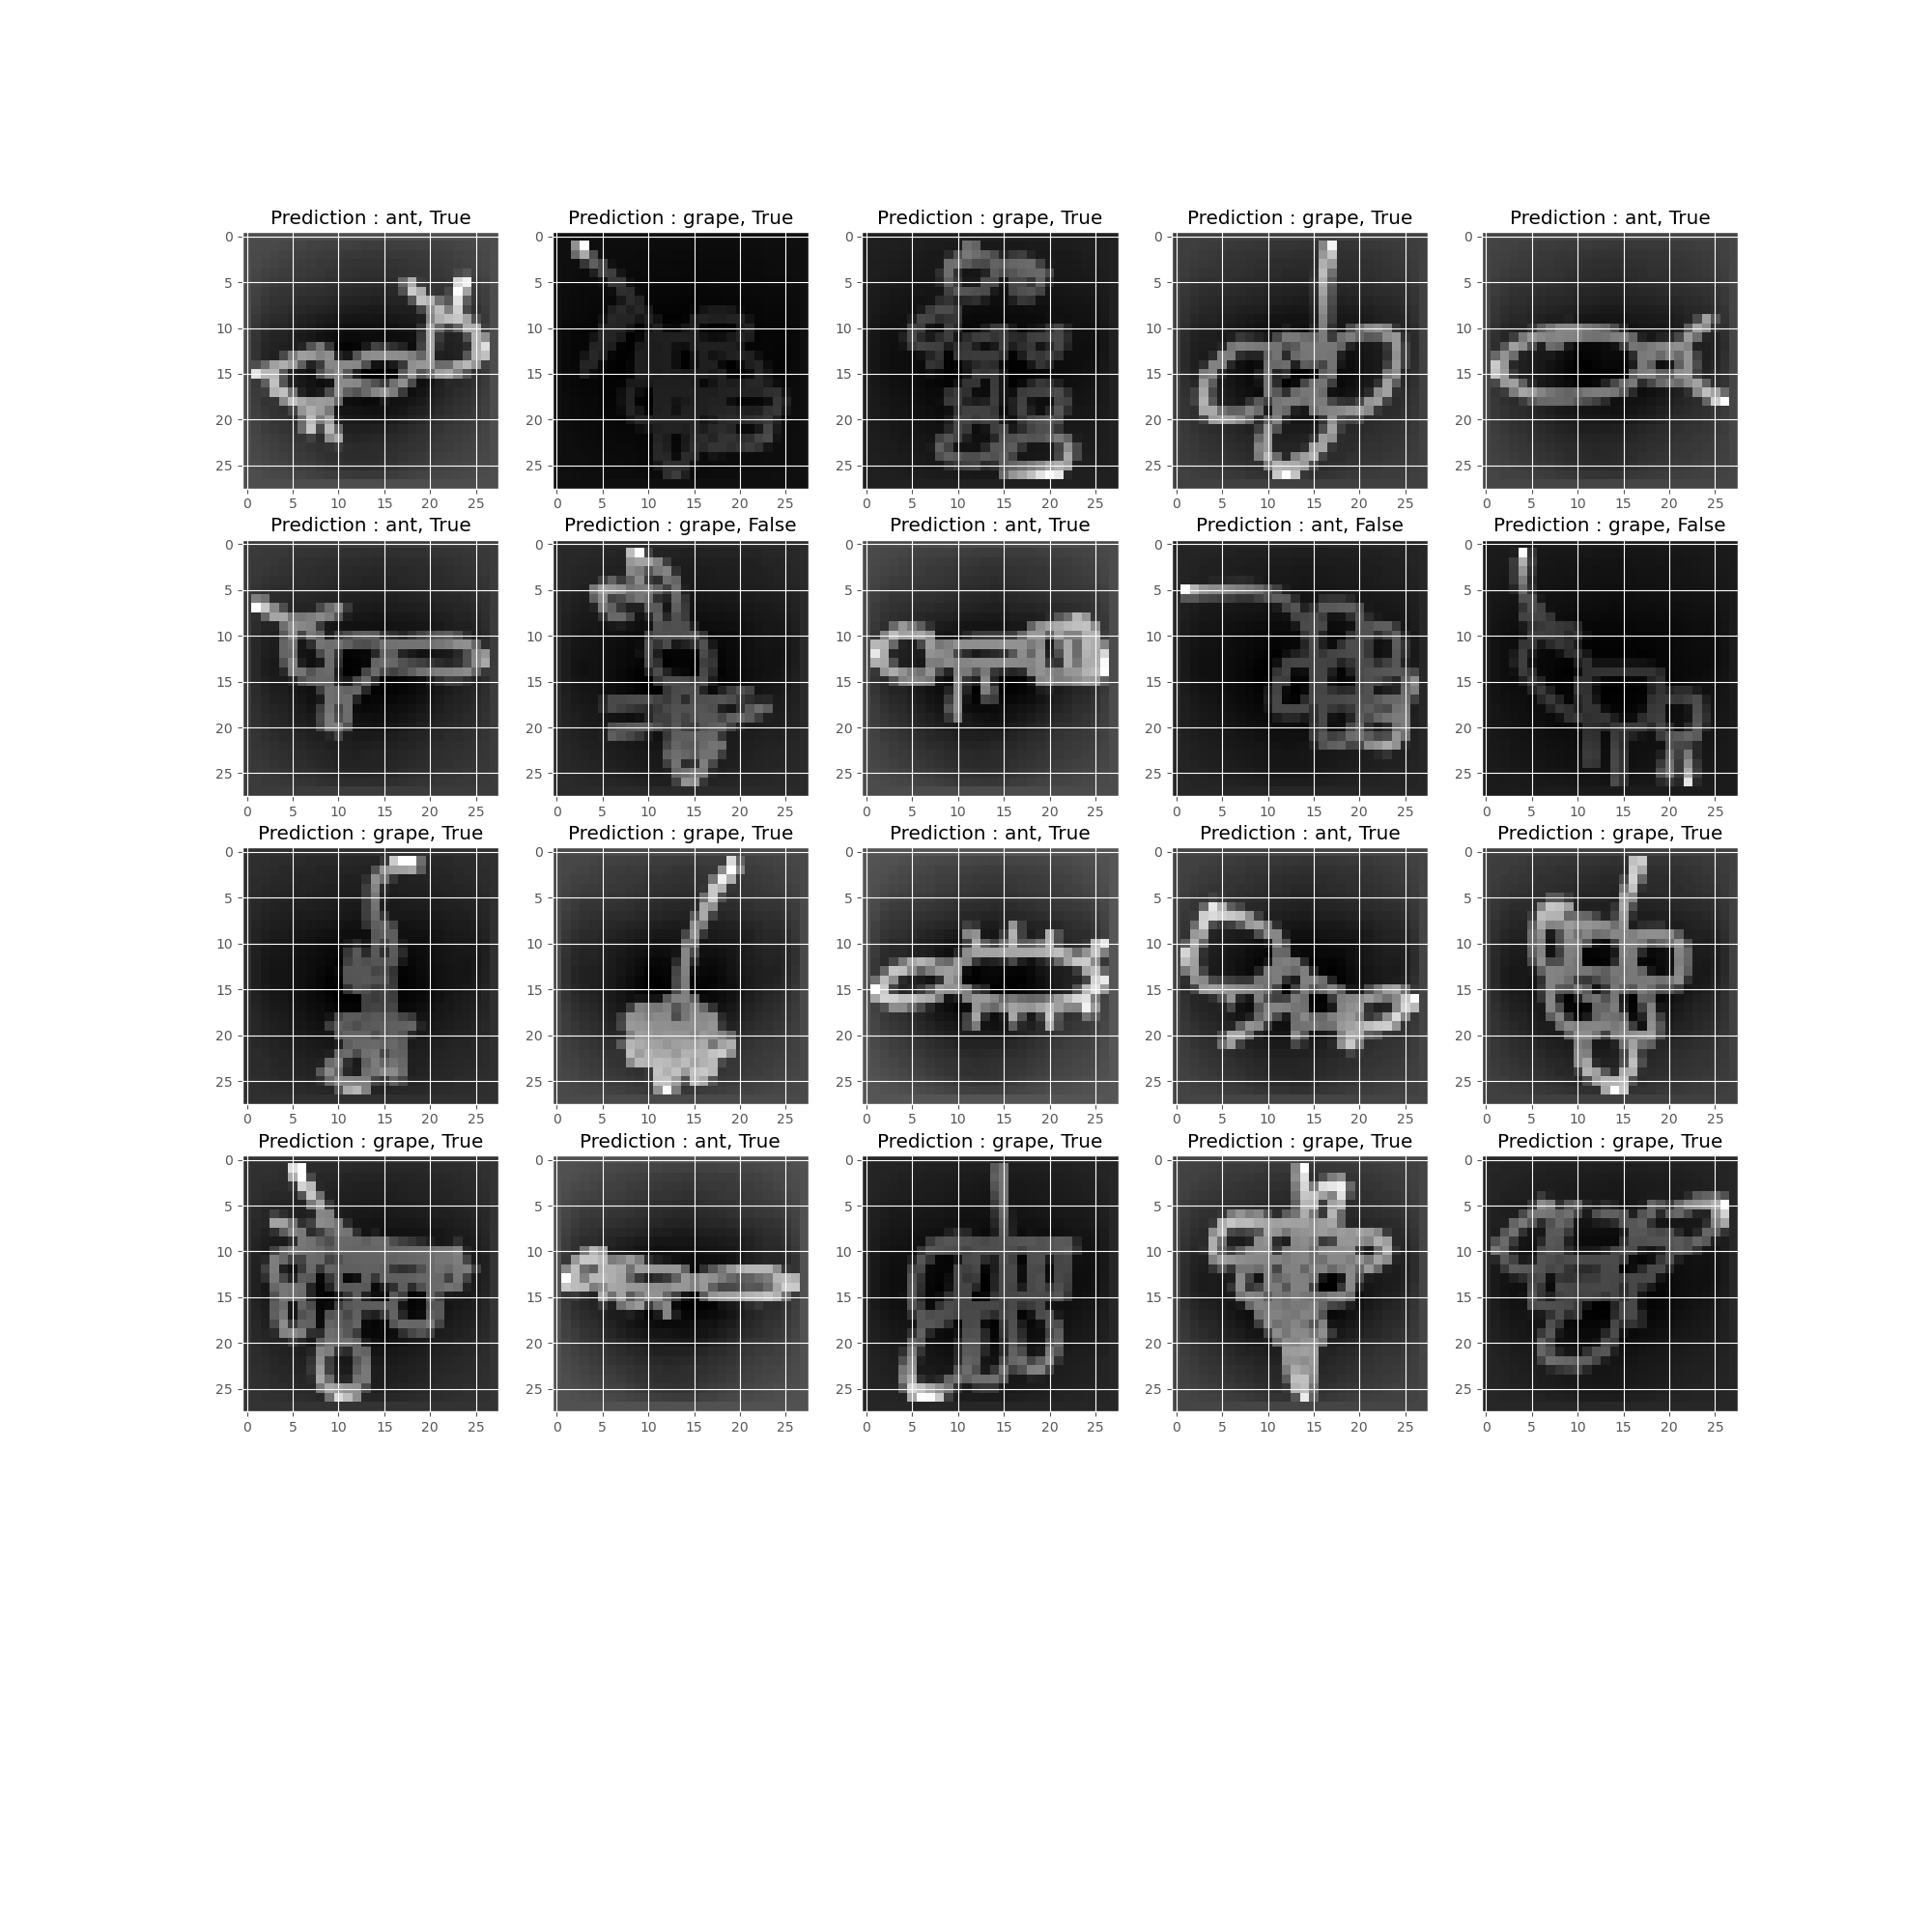

16/16 [==============================] - 0s 1ms/step - loss: 0.6292 - accuracy: 0.8620
[0.6292246580123901, 0.8619999885559082]


In [543]:
model.fit(
   x=X_train,
   y=Y_train,
   epochs=2,
   batch_size=32,
    verbose = 0, 
   validation_data = (X_test, Y_test)
)
prediction = model.predict(
    x=X_test,
    batch_size=32,
    verbose=0
)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if np.argmax(prediction[tpm]) != np.argmax(Y_test[tpm]):
        correct = False
    if np.argmax(prediction[tpm])==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))
print(model.evaluate(X_test, Y_test))

### With a larger architecture

$$ (784) \rightarrow (300) \rightarrow (128) \rightarrow (84) \rightarrow (2) $$

In [545]:
epochs = 15
model = Sequential([
   Dense(output_shape, activation='sigmoid', input_shape=(input_shape,)),
    Flatten(),
   Dense(128, activation='softmax'),
    Flatten(),
    Dense(84, activation='softmax'),
    Flatten(),
    Dense(2, activation='softmax')
    ])
model.compile(
   optimizer='sgd',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)
history = model.fit(
   x=X_train,
   y=Y_train,
   epochs=epochs,
   batch_size=64,
    verbose = 0, 
   validation_data = (X_test, Y_test)
)

<IPython.core.display.Javascript object>


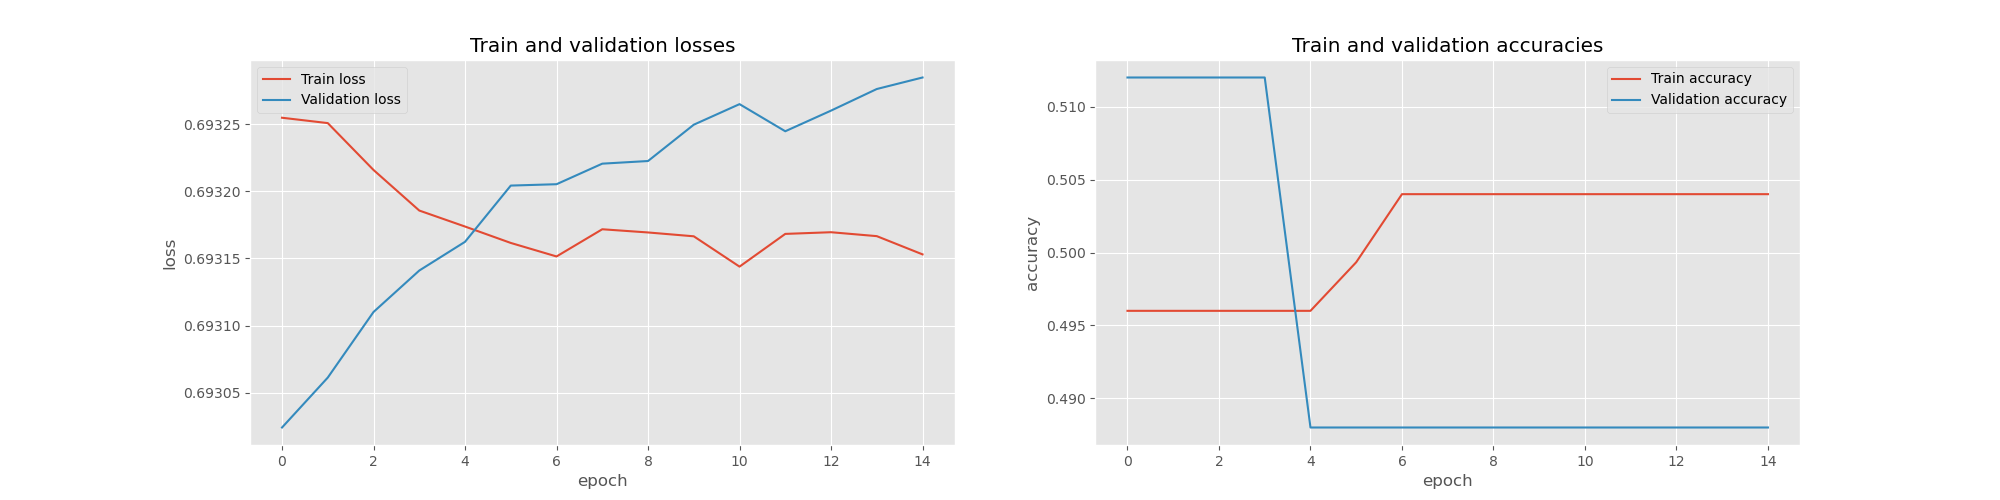

In [546]:
plt.close("all")
_, axes = plt.subplots(1, 2, figsize=(20, 5))

# summarize history for loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Train and validation losses')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['Train loss', 'Validation loss'], loc='best')

# summarize history for accuracy
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Train and validation accuracies')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend(['Train accuracy', 'Validation accuracy'], loc='best')
plt.show()


In [547]:
model.evaluate(X_test, Y_test)

16/16 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4880


[0.693284809589386, 0.4880000054836273]

In [544]:
accuracy = 0
epochs_optim = 2
batch_optim = 32
for epochs in range(2,21):
    for batch in [32*k for k in range(1,4)]:
        history = model.fit(
   x=X_train,
   y=Y_train,
   epochs=epochs,
   batch_size=batch,
    verbose = 0, 
   validation_data = (X_test, Y_test))
        if model.evaluate(X_test, Y_test, verbose=0)[1] > accuracy :
            accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
            epochs_optim = epochs
            batch_optim = batch
print(accuracy)
print(epochs_optim)
print(batch_optim)

0.8619999885559082
2
32


<IPython.core.display.Javascript object>


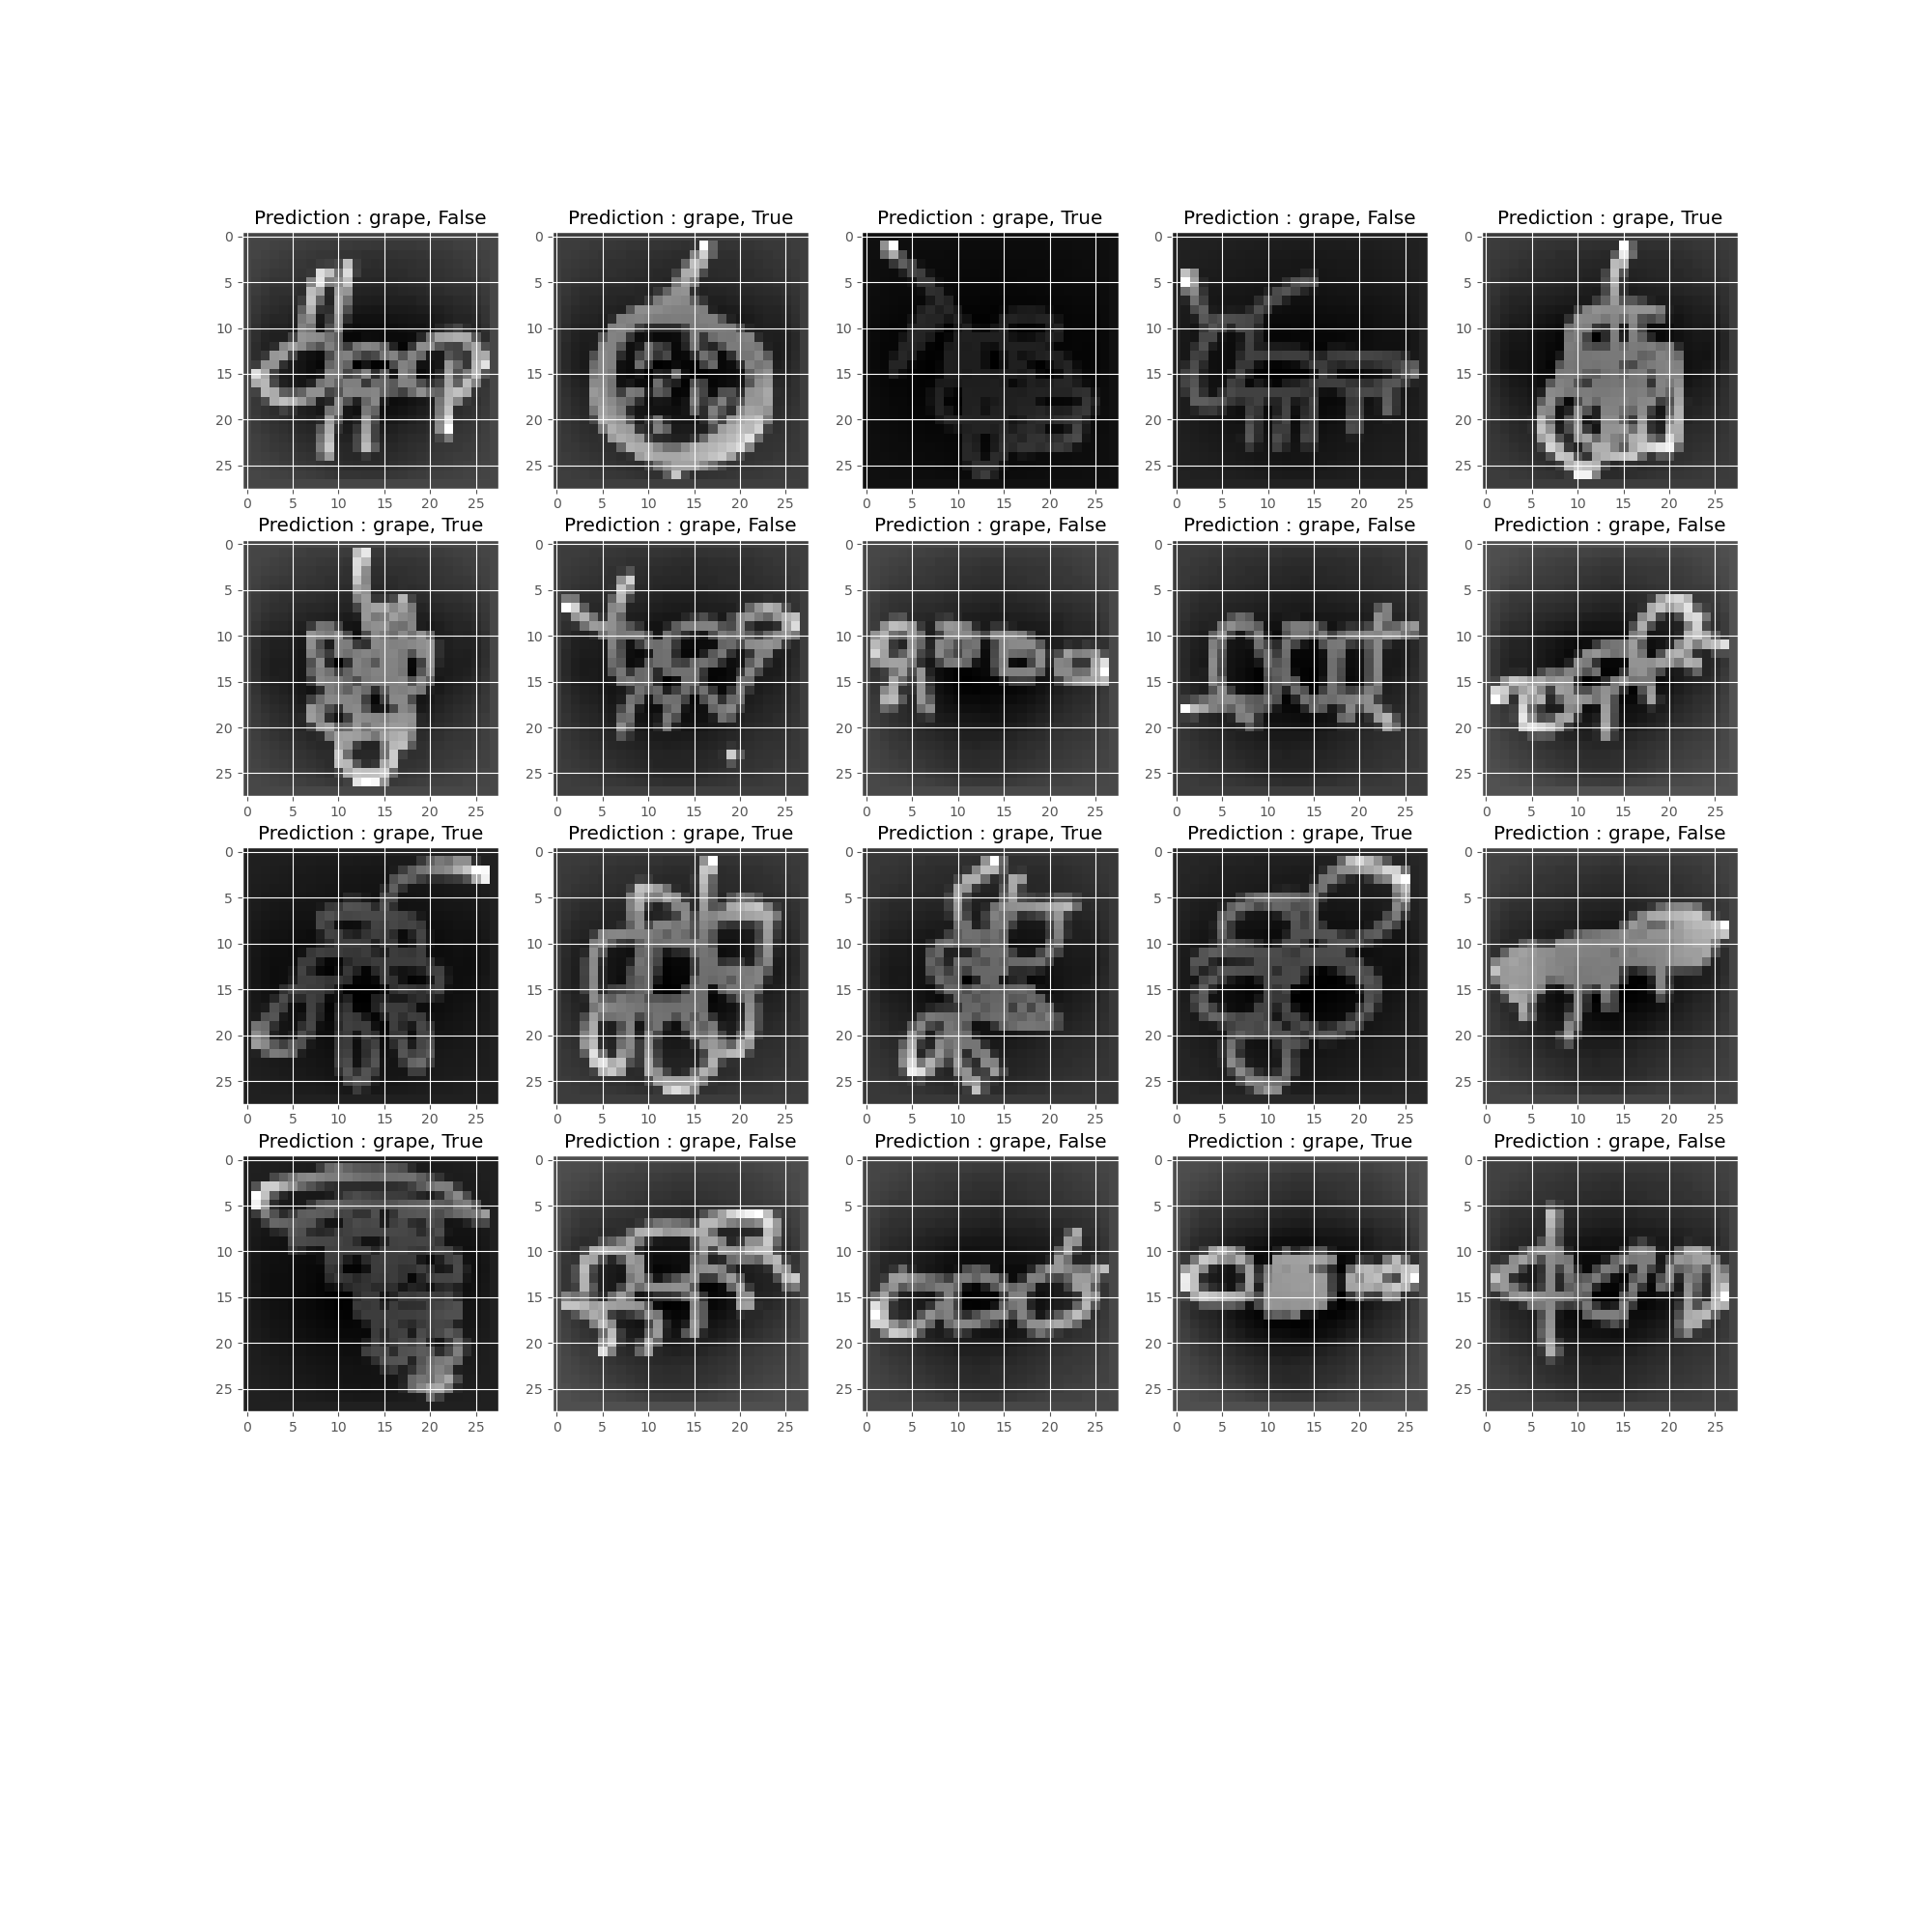

16/16 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.4880
[0.6933168768882751, 0.4880000054836273]


In [548]:
model.fit(
   x=X_train,
   y=Y_train,
   epochs=2,
   batch_size=32,
    verbose = 0, 
   validation_data = (X_test, Y_test)
)
prediction = model.predict(
    x=X_test,
    batch_size=32,
    verbose=0
)
fig = plt.figure(figsize=(20,20))
for i in range(1,21):
    plt.subplot(5, 5, i)
    tpm = np.random.randint(0,len(X_test))
    plt.imshow(X_test[tpm].reshape((28,28)), cmap=plt.get_cmap('gray'))
    # Prediction
    correct = True
    if np.argmax(prediction[tpm]) != np.argmax(Y_test[tpm]):
        correct = False
    if np.argmax(prediction[tpm])==0:
        label_predicted = "ant"
    else:
        label_predicted = "grape"
    plt.title("Prediction : " + label_predicted + ", " + str(correct))
print(model.evaluate(X_test, Y_test))

# Conclusion

It appears that the classifier given by the SVM is the best one. However, the classifiers given by the random forest or the neural network for a sigmoid activation function and a small architecture